December 2021, computed and edited 

Article's title: Transmission of gram-negative antibiotic resistant bacteria following high and low exposure to antibiotic resistance reservoirs in a rural community: a modelling study

# Librarys

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
import pandas as pd

# Functions

In [47]:
#Differential equations
plt.rcParams["font.family"] = "Times New Roman"
def df1(y,t,params):   
    S,ZC,ZH,IC,IHC,IHH,MC, MH = y
    Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho,delta,delta_I,epsilon = params
    
    dS = Lambda*(S+ZC+ZH+IC+IHC+IHH) + gamma*ZC + gamma*ZH - rho*epsilon*(beta_C*S*ZC) - rho*delta*epsilon*(beta_H*S*ZH) - phi*S
    
    dZC = rho*epsilon*(beta_C*S*ZC) + omega_C*IC + alpha*ZH - xi_C*(1-gamma)*(1-delta)*ZC - delta*ZC - gamma*ZC - phi*ZC
    
    dZH = rho*delta*epsilon*(beta_H*S*ZH) + delta*ZC + omega_H*(IHH+IHC) - xi_H*(1-alpha)*ZH - alpha*ZH - phi*ZH - gamma*ZH
    
    dIC = xi_C*(1-gamma)*(1-delta)*ZC - delta_I*IC - omega_C*IC - (1-omega_C)*(1-delta_I)*eta*V_C*IC - phi*IC
    
    dIHC = delta_I*IC-omega_H*IHC-(1-omega_H)*eta*V_H*IHC-phi*IHC
    
    dIHH = xi_H*(1-alpha)*ZH-omega_H*IHH-(1-omega_H)*eta*V_H*IHH-phi*IHH
    
    dRC = (1-omega_C)*(1-delta_I)*eta*V_C*IC
    
    dRH = (1-omega_H)*eta*V_H*(IHC+IHH)

    derivs = [dS,dZC,dZH,dIC,dIHC,dIHH,dRC,dRH]
        
    return derivs


#intervalo de confianza usando montecarlo

def CI_v1 (RESULTS):
# inputs:
# RESULTS[i] = resultado correspondiente a beta[i]
# RESULTS[i][:,j] = serie de tiempo para el compartimento j

#outputs:
#entrega mean = arreglo con los promedios, donde mean[i] corresponde a la serie del 
#    compartimento i 
#    low = arreglo con el límite inferior de intervalo de confianza al 95%, donde 
#    low[i] corresponde a la serie del comparimento i
#    up = arreglo con el límite inferior de intervalo de confianza al 95%, donde 
#    up[i] corresponde a la serie del comparimento i
#    MATRIZ = arreglo que reordena los elementos de RESULT, donde MATRIZ[c] es son
#    los resultados para el compartimento c, y donde MATRIZ[c][:,i] es la serie de tiempo
#    para el beta[i]
    
    n_beta = len(RESULTS)
    n_compartment = np.size(RESULTS[1],1)
    T = np.size(RESULTS[1],0)
    
    mean = []
    low = []
    up = []
    
    MATRIZ = []
    
    for c in range(n_compartment):

        matriz = np.zeros([T,n_beta])
        
        for i in range(n_beta):
            matriz[:,i] = RESULTS[i][:,c]
        
        mean_c =  np.mean(matriz,axis=1)
        std_c = np.std(matriz,axis=1)
#        se_c = std_c/np.sqrt(n_beta)
        
        low_c = mean_c - 1.96*std_c
        up_c = mean_c + 1.96*std_c
        
        mean.append(mean_c)
        low.append(low_c)
        up.append(up_c)
        MATRIZ.append(matriz)
        
    return mean, low, up, MATRIZ

#intervalo de confianza usando promedio de la serie

def CI_v2 (RESULTS):
# RESULTS[i] = resultado correspondiente a la serie de tiempo del compartimento i
    
    n_compartment = np.size(RESULTS,1)
    T = np.size(RESULTS,0)
    

    low = np.zeros([T,n_compartment])
    up = np.zeros([T,n_compartment])
    
    for i in range(n_compartment):
        
        std_i = np.std(RESULTS[:,i])
        low[:,i] = RESULTS[:,i]-1.96*std_i
        up[:,i] = RESULTS[:,i]+1.96*std_i
        
    return low, up


def comparative_table_avit(RESULTS,baseline,variations): #avit = average variation in time
    
    #extract the baseline result
    baseline_index = np.where(variations == baseline)[0][0]
    RESULTS_baseline = RESULTS[baseline_index]

    #generamos matriz vacia donde guardar los resultados
    variation_matrix = np.zeros([len(RESULTS_baseline[0]),len(RESULTS)])

    #recorremos los resultados

    for i in range(len(RESULTS)):
        RESULTS_i = RESULTS[i]
    
        #recorremos compartimentos
        for j in range(len(RESULTS_baseline[0])):
            compartment_baseline = RESULTS_baseline[:,j]
            compartment_i = RESULTS_i[:,j]
            
            comparition = (compartment_i-compartment_baseline)/compartment_baseline
            average_comparition = np.nanmean(comparition)
        
            variation_matrix[j,i] = average_comparition
    
    return variation_matrix


def comparative_table_max(RESULTS,baseline,variations):
    #extract the baseline result
    baseline_index = np.where(variations == baseline)[0][0]
    RESULTS_baseline = RESULTS[baseline_index]


    #generamos matriz vacia donde guardar los resultados
    variation_matrix = np.zeros([len(RESULTS_baseline[0]),len(RESULTS)])

    #recorremos los resultados

    for i in range(len(RESULTS)):
        RESULTS_i = RESULTS[i]
    
        #recorremos compartimentos
        for j in range(len(RESULTS_baseline[0])):
            compartment_baseline = RESULTS_baseline[:,j]
            compartment_i = RESULTS_i[:,j]
        
            max_compartment_baseline = np.max(compartment_baseline)
            max_compartment_i = np.max(compartment_i)
            
            comparition = (max_compartment_i-max_compartment_baseline)/max_compartment_baseline
        
            variation_matrix[j,i] = comparition
        
    return variation_matrix

# Parameters and Initial Conditions

In [48]:
#parameters

Lambda= 0.000032
phi= 0.000019
xi_C= 0.00011
xi_H= 0.011
V_C= 0.368
V_H= 0.368/1.31
alpha = 0.32
gamma= 0.033
beta_H = 0.0005308
beta_C = beta_H*0.25
omega_H= 0.2
omega_C= 0.25*0.2
eta= 0.1
rho= np.array([1,1.27])
delta= 0.000054
delta_I= 0.8
epsilon= 0.01253

#Initial Conditions

N = 46000

S_0 = 0.5*N

Hospitalized = 0.0025*N 
Infected_Hospital = Hospitalized*0.0842


ZH_0 = Hospitalized*(1-0.0842)

IC_0 = Hospitalized*0.0842*0.5

IHC_0 = Infected_Hospital*0.87
IHH_0 = Infected_Hospital*0.17

ZC_0 = N-S_0-ZH_0-IC_0-IHC_0-IHH_0

RC_0 = 0
RH_0 = 0

y0 = [S_0,ZC_0,ZH_0,IC_0,IHC_0,IHH_0,RC_0,RH_0]
compartment_names = [r'$S$',r'$Z_C$',r'$Z_H$',r'$I_C$',r'$I_{HC}$',r'$I_{HH}$',r'$R_C$',r'$R_H$',r'$I_H$','N']

colors = {r'$S$':'goldenrod',
          r'$Z_C$':'blue',r'$Z_H$':'green',
          r'$I_C$':'red',r'$I_{HC}$':'purple',r'$I_{HH}$':'brown',
          r'$R_C$':'black',r'$R_H$':'chocolate',
          r'$I_H$':'orange','N':'darkblue'}

#timeline

tInc = 1
tStop = 700
t = np.arange(0,tStop,tInc)

# A]- Baseline

In [4]:
#resultados

RESULTS_baseline = []


for r in range(len(rho)):
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho[r],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    N = psoln[:,0]+psoln[:,1]+psoln[:,2]+psoln[:,3]+psoln[:,4]+psoln[:,5] #calculamos N
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    solutions = np.append(solutions,np.atleast_2d(N).T, axis=1)

    RESULTS_baseline.append(solutions)

<ipython-input-180-8867dd35d049>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,r+1)
<ipython-input-180-8867dd35d049>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,r+1)
<ipython-input-180-8867dd35d049>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created an

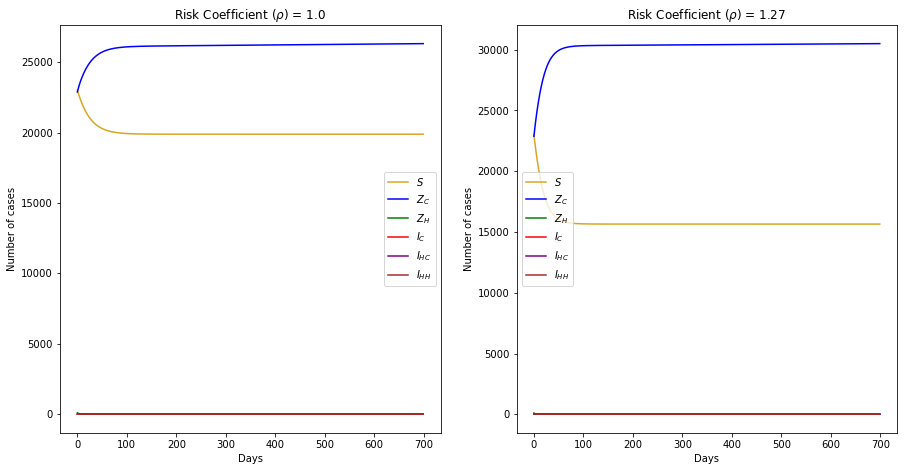

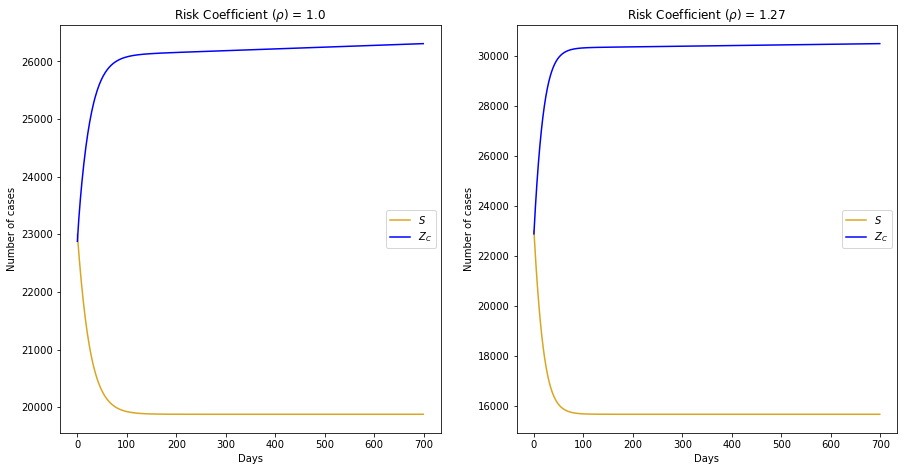

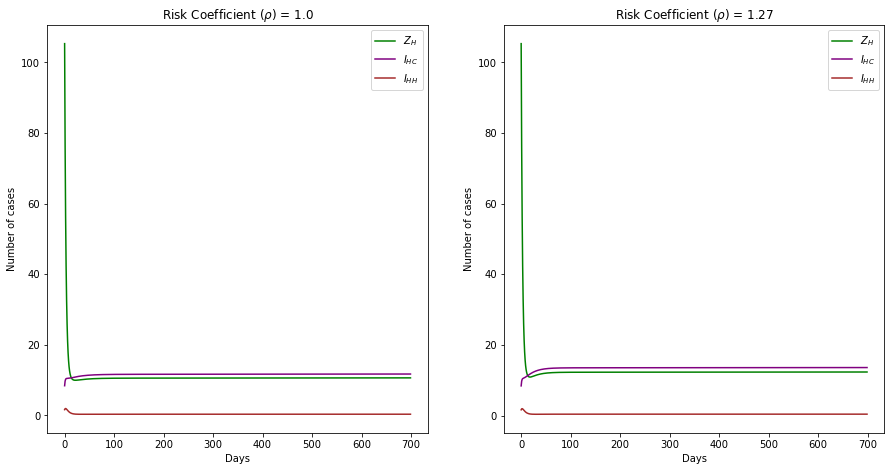

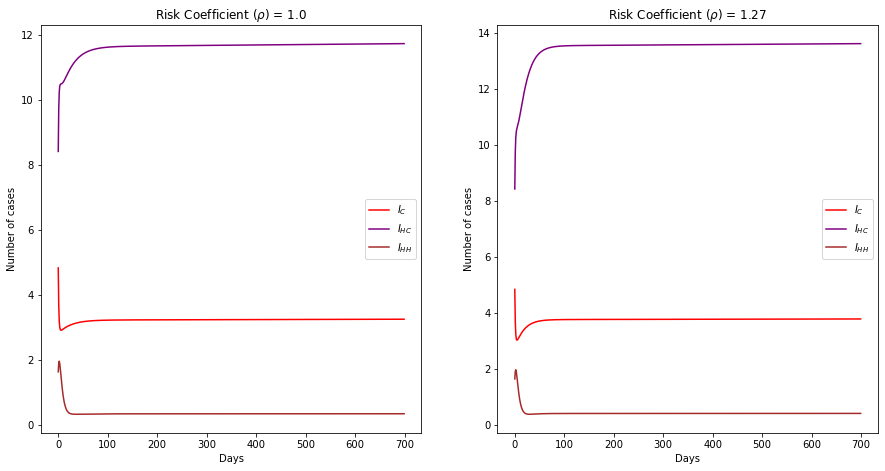

In [180]:
#gráficos

#TODOS    
f1, ax1 = plt.subplots(1,2, figsize=(15,7.5))    
for r in range(len(rho)): 
    for i in range(8):
        solutions = RESULTS_baseline[r]
        if i<=5  :
            plt.subplot(1,2,r+1)
            plt.plot(solutions[:,i],label = compartment_names[i],color = colors[compartment_names[i]])
            plt.title(r'Risk Coefficient ($\rho$) = '+str(rho[r]))
            plt.xlabel('Days')
            plt.ylabel('Number of cases')
            plt.grid(color='white')
            plt.legend()
            
#COMUNIDAD   
f2, ax2 = plt.subplots(1,2, figsize=(15,7.5))    
for r in range(len(rho)): 
    for i in range(8):
        solutions = RESULTS_baseline[r]
        if i==0 or i == 1   :
            plt.subplot(1,2,r+1)
            plt.plot(solutions[:,i],label = compartment_names[i],color = colors[compartment_names[i]])
            plt.title(r'Risk Coefficient ($\rho$) = '+str(rho[r]))
            plt.xlabel('Days')
            plt.ylabel('Number of cases')
            plt.grid(color='white')
            plt.legend()
            
#HOSPITAL 
f2, ax2 = plt.subplots(1,2, figsize=(15,7.5))    
for r in range(len(rho)): 
    for i in range(8):
        solutions = RESULTS_baseline[r]
        if i==2 or i == 4 or i == 5  :
            plt.subplot(1,2,r+1)
            plt.plot(solutions[:,i],label = compartment_names[i],color = colors[compartment_names[i]])
            plt.title(r'Risk Coefficient ($\rho$) = '+str(rho[r]))
            plt.xlabel('Days')
            plt.ylabel('Number of cases')
            plt.grid(color='white')
            plt.legend()
            
#INFECTADOS
f3, ax3 = plt.subplots(1,2, figsize=(15,7.5))    
for r in range(len(rho)): 
    solutions = RESULTS_baseline[r]
    for i in range(8):
        solutions = RESULTS_baseline[r]
        if i==3 or i == 4 or i == 5  :
            plt.subplot(1,2,r+1)
            plt.plot(solutions[:,i],label = compartment_names[i],color = colors[compartment_names[i]])
            plt.title(r'Risk Coefficient ($\rho$) = '+str(rho[r]))
            plt.xlabel('Days')
            plt.ylabel('Number of cases')
            plt.grid(color='white')
            plt.legend()

<ipython-input-181-82a1c3119530>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,r+1)
<ipython-input-181-82a1c3119530>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,r+1)
<ipython-input-181-82a1c3119530>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created an

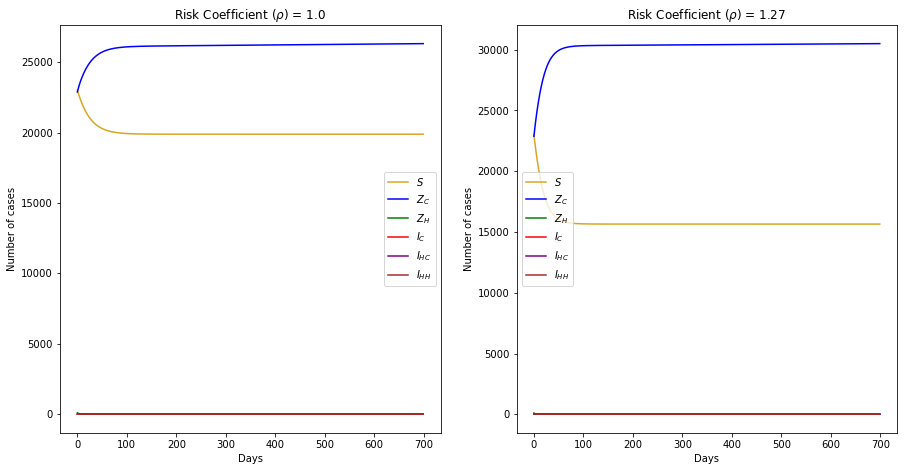

In [181]:
f1, ax1 = plt.subplots(1,2, figsize=(15,7.5))    
for r in range(len(rho)): 
    for i in range(8):
        solutions = RESULTS_baseline[r]
        if i<=5  :
            plt.subplot(1,2,r+1)
            plt.plot(solutions[:,i],label = compartment_names[i], color = colors[compartment_names[i]])
            plt.title(r'Risk Coefficient ($\rho$) = '+str(rho[r]))
            plt.xlabel('Days')
            plt.ylabel('Number of cases')
            plt.grid(color='white')
            plt.legend()

In [5]:
# Tabla con los resultados 

columns = ['S','ZC','ZH','IC','IHC','IHH','RC','RH','IH','N']

df_results_lowRisk = pd.DataFrame(RESULTS_baseline[0],columns=columns, index = t)
df_results_highRisk = pd.DataFrame(RESULTS_baseline[1],columns=columns, index = t)

In [7]:
#Exporting results to CSV
df_results_lowRisk.to_csv('resultsLowRisk.csv')
df_results_highRisk.to_csv('resultsHighRisk.csv')

In [186]:
df_results_highRisk

,S,ZC,ZH,IC,IHC,IHH,RC,RH,IH,N
0,23000.000000,22879.771180,105.317000,4.841500,8.424210,1.646110,0.000000,0.000000,10.070320,46000.000000
1,22653.362362,23255.263960,76.339702,3.704703,9.733895,1.917273,0.029294,0.246814,11.651168,46000.321895
2,22317.267456,23611.569265,56.313931,3.248240,10.254395,1.973047,0.053354,0.516320,12.227442,46000.626334
3,21992.193927,23950.862927,42.418143,3.079252,10.465180,1.905991,0.075371,0.793228,12.371170,46000.925420
4,21678.438541,24274.666809,32.749256,3.031128,10.563850,1.774687,0.096689,1.071073,12.338537,46001.224270
...,...,...,...,...,...,...,...,...,...,...
695,15652.108860,30498.982949,12.349276,3.785213,13.609710,0.415156,18.234263,216.949850,14.024866,46181.251165
696,15652.108833,30499.241425,12.349381,3.785246,13.609825,0.415160,18.260729,217.265036,14.024985,46181.509870
697,15652.108806,30499.499903,12.349486,3.785278,13.609941,0.415163,18.287196,217.580225,14.025104,46181.768576
698,15652.108780,30499.758380,12.349590,3.785310,13.610056,0.415167,18.313663,217.895416,14.025223,46182.027282


In [187]:
df_results_lowRisk

,S,ZC,ZH,IC,IHC,IHH,RC,RH,IH,N
0,23000.000000,22879.771180,105.317000,4.841500,8.424210,1.646110,0.000000,0.000000,10.070320,46000.000000
1,22885.856927,23022.787439,76.333799,3.695183,9.731328,1.917258,0.029270,0.246798,11.648587,46000.321934
2,22774.539780,23154.364971,56.292278,3.218387,10.238330,1.972946,0.053197,0.516119,12.211276,46000.626692
3,22666.279840,23276.922137,42.372039,3.025040,10.421975,1.905684,0.074921,0.792382,12.327659,46000.926716
4,22561.207894,23392.142436,32.670741,2.951426,10.480919,1.774024,0.095771,1.068821,12.254943,46001.227440
...,...,...,...,...,...,...,...,...,...,...
695,19880.075007,26307.198013,10.651774,3.264961,11.738980,0.358085,15.747995,187.541327,12.097065,46213.286819
696,19880.074938,26307.503863,10.651898,3.264999,11.739116,0.358089,15.770824,187.813190,12.097205,46213.592903
697,19880.074869,26307.809714,10.652022,3.265037,11.739253,0.358093,15.793653,188.085055,12.097346,46213.898987
698,19880.074800,26308.115565,10.652145,3.265075,11.739389,0.358097,15.816482,188.356924,12.097487,46214.205072


In [194]:
#(relationship between IHHs of different risk scenarios
0.42/0.35

1.2

In [195]:
#(relationship between IHHs of different risk scenarios
18.34/15.84

1.1578282828282829

In [196]:
218/188

1.1595744680851063

In [197]:
14/12

1.1666666666666667

In [198]:
26/46

0.5652173913043478

In [200]:
18.2/15.8

1.1518987341772151

In [201]:
218.2/188.6

1.1569459172852599

In [203]:
13.61/11.739

1.1593832524065082

In [10]:
# A.1]- Population size over time

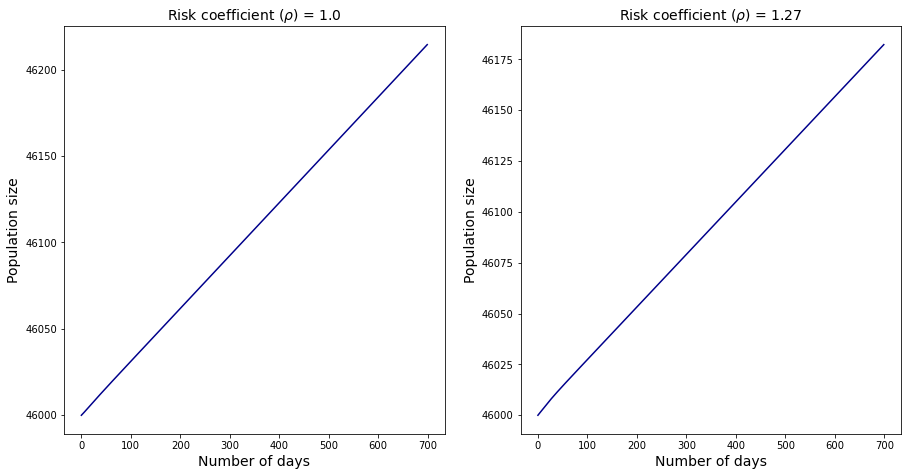

In [128]:
# N total
f4, ax4 = plt.subplots(1,2, figsize=(15,7.5))  
for r in range(len(rho)): 
    solutions = RESULTS_baseline[r]
    
    plt.subplot(1,2,r+1)
    plt.plot(solutions[:,9],label = compartment_names[9],color = colors[compartment_names[9]])
    plt.title(r'Risk coefficient ($\rho$) = '+str(rho[r]), fontsize=14)
    plt.xlabel('Number of days', fontsize=14)
    plt.ylabel('Population size', fontsize=14)
    plt.grid(color='white')
    #plt.legend()
    plt.savefig("Popsize.pdf", dpi=250)

In [12]:
# A.2]- Number of deaths over time

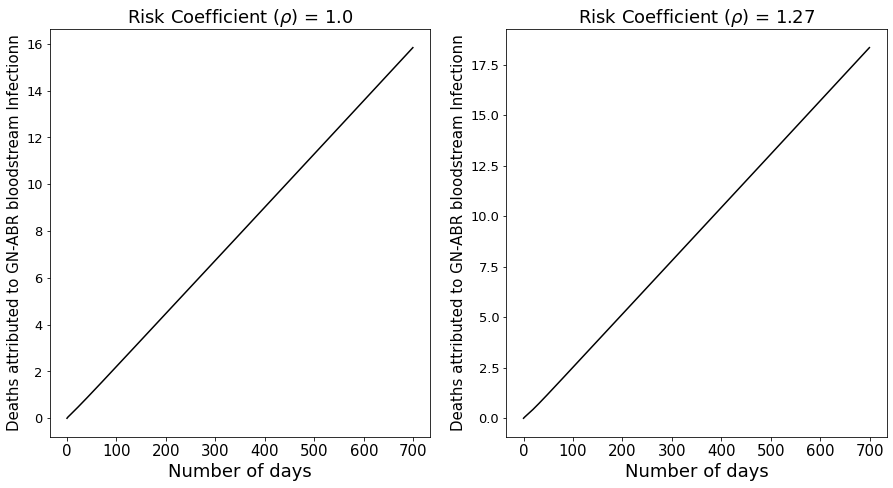

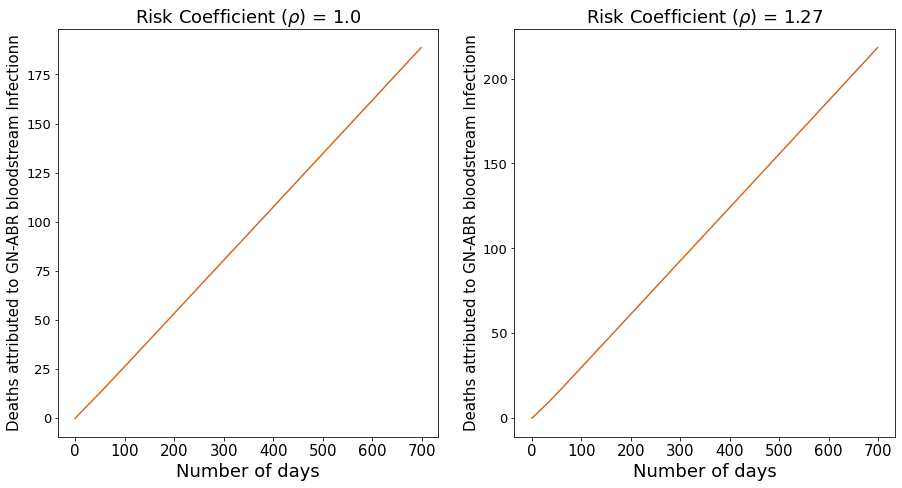

In [6]:
# Muertos ocasionados por infección

#En comunidad
f5, ax5 = plt.subplots(1,2, figsize=(15,7.5))  
for r in range(len(rho)): 
    solutions = RESULTS_baseline[r]
    
    plt.subplot(1,2,r+1)
    plt.plot(solutions[:,6],label = compartment_names[6], color = colors[compartment_names[6]])
    plt.title(r'Risk Coefficient ($\rho$) = '+str(rho[r]), fontsize=18)
    plt.xlabel('Number of days', fontsize=18)
    plt.ylabel('Deaths attributed to GN-ABR bloodstream Infectionn', fontsize=15)
    plt.grid(color ='white')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=13)
    #plt.legend()
plt.savefig("MortalitybyriskCommunity.pdf", dpi=250)

#En hospital
f6, ax6 = plt.subplots(1,2, figsize=(15,7.5))  
for r in range(len(rho)): 
    solutions = RESULTS_baseline[r]
    
    plt.subplot(1,2,r+1)
    plt.plot(solutions[:,7],label = compartment_names[7], color = colors[compartment_names[7]])
    plt.title(r'Risk Coefficient ($\rho$) = '+str(rho[r]), fontsize=18)
    plt.xlabel('Number of days', fontsize=18)
    plt.ylabel('Deaths attributed to GN-ABR bloodstream Infectionn', fontsize=15)
    plt.grid(color ='white')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=13)
    #plt.legend()
    
plt.savefig("MortalitybyriskHospital.pdf", dpi=250)

# Montecarlo Simulation All Separated

Low Risk

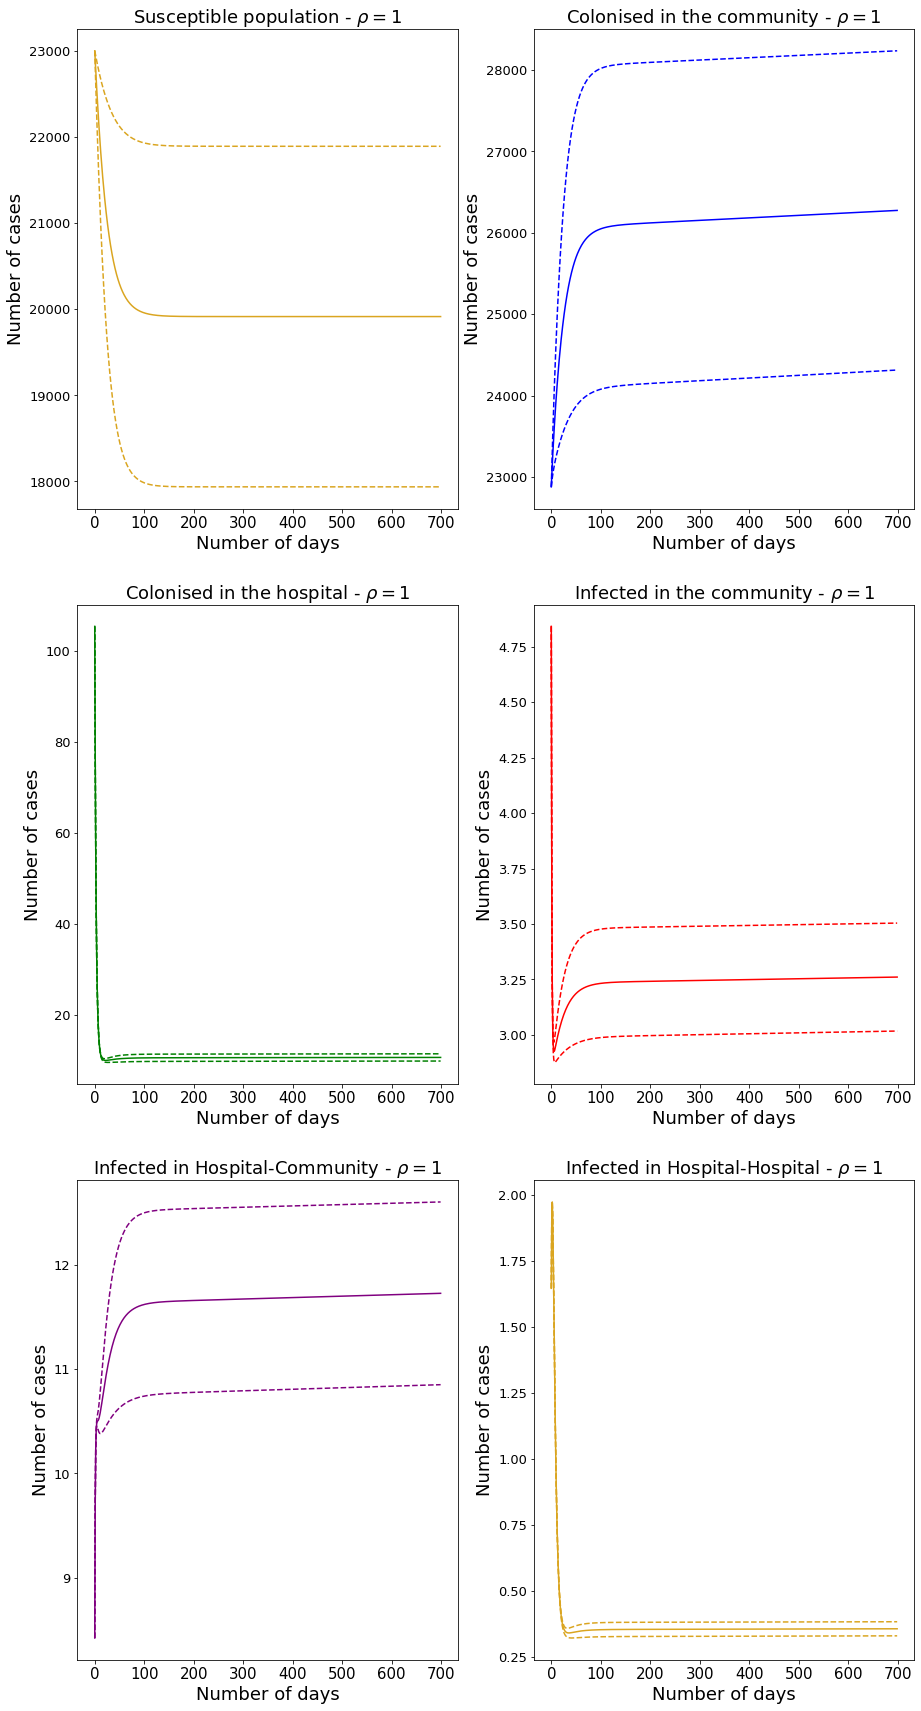

In [120]:
beta_H_mean = 0.0005308
beta_H_ste = ((0.0005308-0.0004775)/1.96)
BETA_H =  np.random.normal(beta_H_mean,beta_H_ste,1000)

RESULTS_lowRisk = []

for beta_H_i in BETA_H: 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H_i,beta_H_i*0.25,omega_H,omega_C,eta,rho[0],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_lowRisk.append(solutions)   


mean,low,up,MATRIZ = CI_v1(RESULTS_lowRisk)


f, ax = plt.subplots(3,2, figsize=(15,30))    
plt.subplot(3,2,1)
plt.plot(mean[0], linestyle = '-', color = colors[compartment_names[0]])
plt.plot(low[0], linestyle = '--' , color = colors[compartment_names[0]])
plt.plot(up[0], linestyle = '--', color = colors[compartment_names[0]])
plt.title(r'Susceptible population - $\rho=1$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')
 
plt.subplot(3,2,2)
plt.plot(mean[1], linestyle = '-', color = colors[compartment_names[1]])
plt.plot(low[1], linestyle = '--' , color = colors[compartment_names[1]])
plt.plot(up[1], linestyle = '--', color = colors[compartment_names[1]])
plt.title(r'Colonised in the community - $\rho=1$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')

plt.subplot(3,2,3)
plt.plot(mean[2], linestyle = '-', color = colors[compartment_names[2]])
plt.plot(low[2], linestyle = '--' , color = colors[compartment_names[2]])
plt.plot(up[2], linestyle = '--', color = colors[compartment_names[2]])
plt.title(r'Colonised in the hospital - $\rho=1$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')

plt.subplot(3,2,4)
plt.plot(mean[3], linestyle = '-', color = colors[compartment_names[3]])
plt.plot(low[3], linestyle = '--' , color = colors[compartment_names[3]])
plt.plot(up[3], linestyle = '--', color = colors[compartment_names[3]])
plt.title(r'Infected in the community - $\rho=1$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')

plt.subplot(3,2,5)
plt.plot(mean[4], linestyle = '-', color = colors[compartment_names[4]])
plt.plot(low[4], linestyle = '--' , color = colors[compartment_names[4]])
plt.plot(up[4], linestyle = '--', color = colors[compartment_names[4]])
plt.title(r'Infected in Hospital-Community - $\rho=1$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')

plt.subplot(3,2,6)
plt.plot(mean[5], linestyle = '-', color = 'goldenrod')
plt.plot(low[5], linestyle = '--' , color = 'goldenrod')
plt.plot(up[5], linestyle = '--', color = 'goldenrod')
plt.title(r'Infected in Hospital-Hospital - $\rho=1$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')


plt.savefig("Montecarlo_P_1.pdf", dpi=250)

High Risk

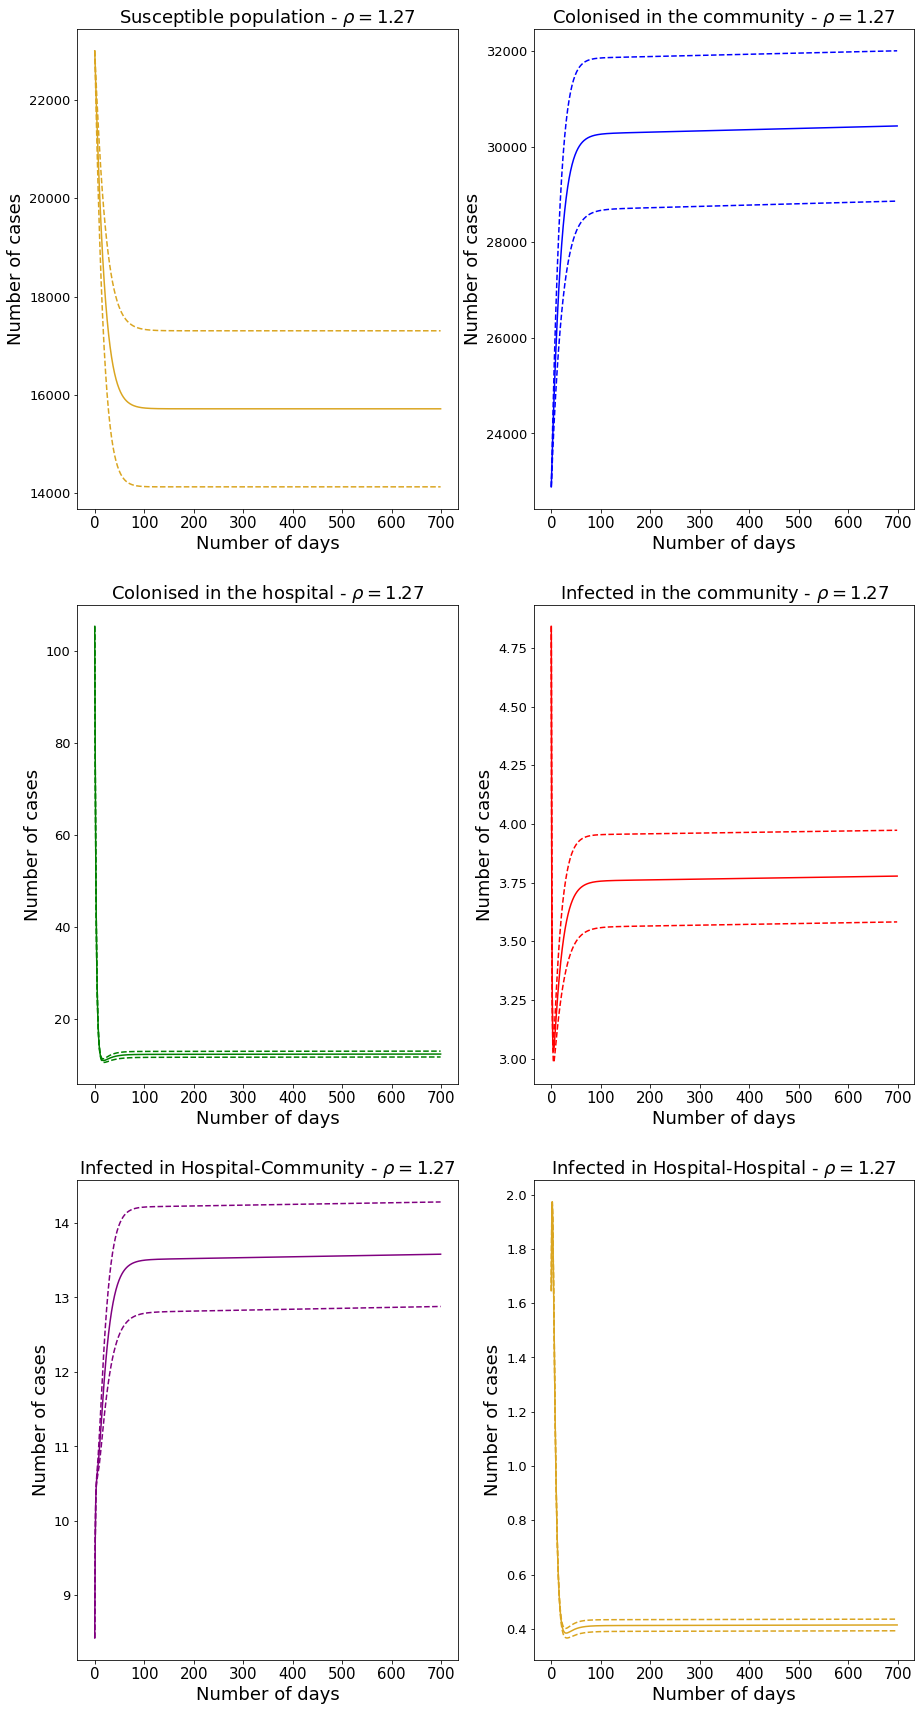

In [121]:
beta_H_mean = 0.0005308
beta_H_ste = ((0.0005308-0.0004775)/1.96)
BETA_H =  np.random.normal(beta_H_mean,beta_H_ste,1000)

RESULTS_highRisk = []

for beta_H_i in BETA_H: 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H_i,beta_H_i*0.25,omega_H,omega_C,eta,rho[1],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_highRisk.append(solutions)   


mean,low,up,MATRIZ = CI_v1(RESULTS_highRisk)


f, ax = plt.subplots(3,2, figsize=(15,30))    

plt.subplot(3,2,1)
plt.plot(mean[0], linestyle = '-', color = colors[compartment_names[0]])
plt.plot(low[0], linestyle = '--' , color = colors[compartment_names[0]])
plt.plot(up[0], linestyle = '--', color = colors[compartment_names[0]])
plt.title(r'Susceptible population - $\rho=1.27$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')
 
plt.subplot(3,2,2)
plt.plot(mean[1], linestyle = '-', color = colors[compartment_names[1]])
plt.plot(low[1], linestyle = '--' , color = colors[compartment_names[1]])
plt.plot(up[1], linestyle = '--', color = colors[compartment_names[1]])
plt.title(r'Colonised in the community - $\rho=1.27$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')

plt.subplot(3,2,3)
plt.plot(mean[2], linestyle = '-', color = colors[compartment_names[2]])
plt.plot(low[2], linestyle = '--' , color = colors[compartment_names[2]])
plt.plot(up[2], linestyle = '--', color = colors[compartment_names[2]])
plt.title(r'Colonised in the hospital - $\rho=1.27$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')

plt.subplot(3,2,4)
plt.plot(mean[3], linestyle = '-', color = colors[compartment_names[3]])
plt.plot(low[3], linestyle = '--' , color = colors[compartment_names[3]])
plt.plot(up[3], linestyle = '--', color = colors[compartment_names[3]])
plt.title(r'Infected in the community - $\rho=1.27$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')

plt.subplot(3,2,5)
plt.plot(mean[4], linestyle = '-', color = colors[compartment_names[4]])
plt.plot(low[4], linestyle = '--' , color = colors[compartment_names[4]])
plt.plot(up[4], linestyle = '--', color = colors[compartment_names[4]])
plt.title(r'Infected in Hospital-Community - $\rho=1.27$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')

plt.subplot(3,2,6)
plt.plot(mean[5], linestyle = '-', color = 'goldenrod')
plt.plot(low[5], linestyle = '--' , color = 'goldenrod')
plt.plot(up[5], linestyle = '--', color = 'goldenrod')
plt.title(r'Infected in Hospital-Hospital - $\rho=1.27$', fontsize=18)
plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.grid(color = 'white')




plt.savefig("Montecarlo_P_127.pdf", dpi=250)

# Montecarlo Simulation : combining risk factors

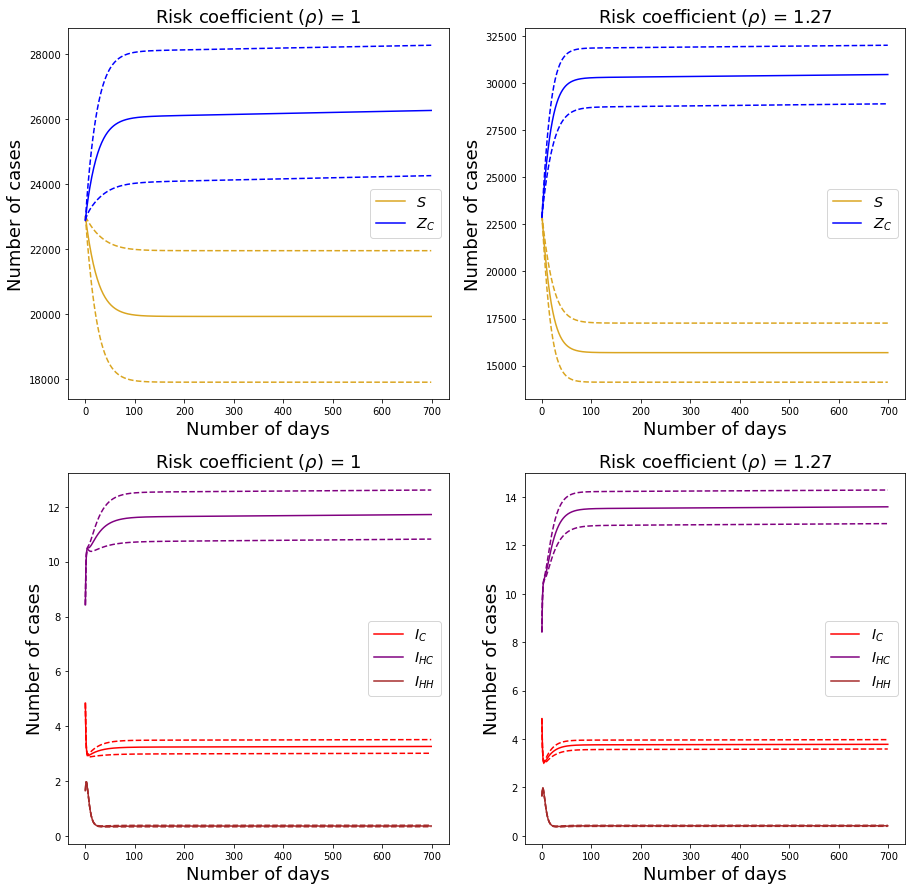

In [117]:
mean_1,low_1,up_1,MATRIZ_1 = CI_v1(RESULTS_lowRisk)
mean_2,low_2,up_2,MATRIZ_2 = CI_v1(RESULTS_highRisk)

f, ax = plt.subplots(2,2, figsize=(15,15))    

# SUSCEPTIBLES Y COLONIZADO EN COMUNIDAD
plt.subplot(2,2,1)

plt.plot(mean_1[0], linestyle = '-', color = colors[compartment_names[0]], label = r'$S$')
plt.plot(low_1[0], linestyle = '--' , color = colors[compartment_names[0]])
plt.plot(up_1[0], linestyle = '--', color = colors[compartment_names[0]])

plt.plot(mean_1[1], linestyle = '-', color = colors[compartment_names[1]], label = r'$Z_C$')
plt.plot(low_1[1], linestyle = '--' , color = colors[compartment_names[1]])
plt.plot(up_1[1], linestyle = '--', color = colors[compartment_names[1]])

plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.title(r'Risk coefficient ($\rho$) = 1', fontsize=18)
plt.legend( fontsize='x-large')

plt.grid(color = 'white')



plt.subplot(2,2,2)

plt.plot(mean_2[0], linestyle = '-', color = colors[compartment_names[0]], label = r'$S$')
plt.plot(low_2[0], linestyle = '--' , color = colors[compartment_names[0]])
plt.plot(up_2[0], linestyle = '--', color = colors[compartment_names[0]])

plt.plot(mean_2[1], linestyle = '-', color = colors[compartment_names[1]], label = r'$Z_C$')
plt.plot(low_2[1], linestyle = '--' , color = colors[compartment_names[1]])
plt.plot(up_2[1], linestyle = '--', color = colors[compartment_names[1]])

plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.title(r'Risk coefficient ($\rho$) = 1.27', fontsize=18)
plt.legend( fontsize='x-large')
plt.grid(color = 'white')


#INFECTADOS 

plt.subplot(2,2,3)

plt.plot(mean_1[3], linestyle = '-', color = colors[compartment_names[3]], label = r'$I_C$')
plt.plot(low_1[3], linestyle = '--' , color = colors[compartment_names[3]])
plt.plot(up_1[3], linestyle = '--', color = colors[compartment_names[3]])

plt.plot(mean_1[4], linestyle = '-', color = colors[compartment_names[4]], label = r'$I_{HC}$')
plt.plot(low_1[4], linestyle = '--' , color = colors[compartment_names[4]])
plt.plot(up_1[4], linestyle = '--', color = colors[compartment_names[4]])

plt.plot(mean_1[5], linestyle = '-', color = colors[compartment_names[5]], label = r'$I_{HH}$')
plt.plot(low_1[5], linestyle = '--' , color = colors[compartment_names[5]])
plt.plot(up_1[5], linestyle = '--', color = colors[compartment_names[5]])

plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.title(r'Risk coefficient ($\rho$) = 1', fontsize=18)
plt.legend( fontsize='x-large')
plt.grid(color = 'white')

plt.subplot(2,2,4)

plt.plot(mean_2[3], linestyle = '-', color = colors[compartment_names[3]], label = r'$I_C$')
plt.plot(low_2[3], linestyle = '--' , color = colors[compartment_names[3]])
plt.plot(up_2[3], linestyle = '--', color = colors[compartment_names[3]])

plt.plot(mean_2[4], linestyle = '-', color = colors[compartment_names[4]], label = r'$I_{HC}$')
plt.plot(low_2[4], linestyle = '--' , color = colors[compartment_names[4]])
plt.plot(up_2[4], linestyle = '--', color = colors[compartment_names[4]])

plt.plot(mean_2[5], linestyle = '-', color = colors[compartment_names[5]], label = r'$I_{HH}$')
plt.plot(low_2[5], linestyle = '--' , color = colors[compartment_names[5]])
plt.plot(up_2[5], linestyle = '--', color = colors[compartment_names[5]])

plt.xlabel('Number of days', fontsize=18)
plt.ylabel('Number of cases', fontsize=18)
plt.title(r'Risk coefficient ($\rho$) = 1.27', fontsize=18)
plt.legend( fontsize='x-large')
plt.grid(color = 'white')


plt.savefig("Montecarlo_Jointresults.pdf", dpi=250)

# Sensitivity analysis : one-way

# 1. Hospitalization Rate for people with community-acquired BSI

#Low-risk scenario

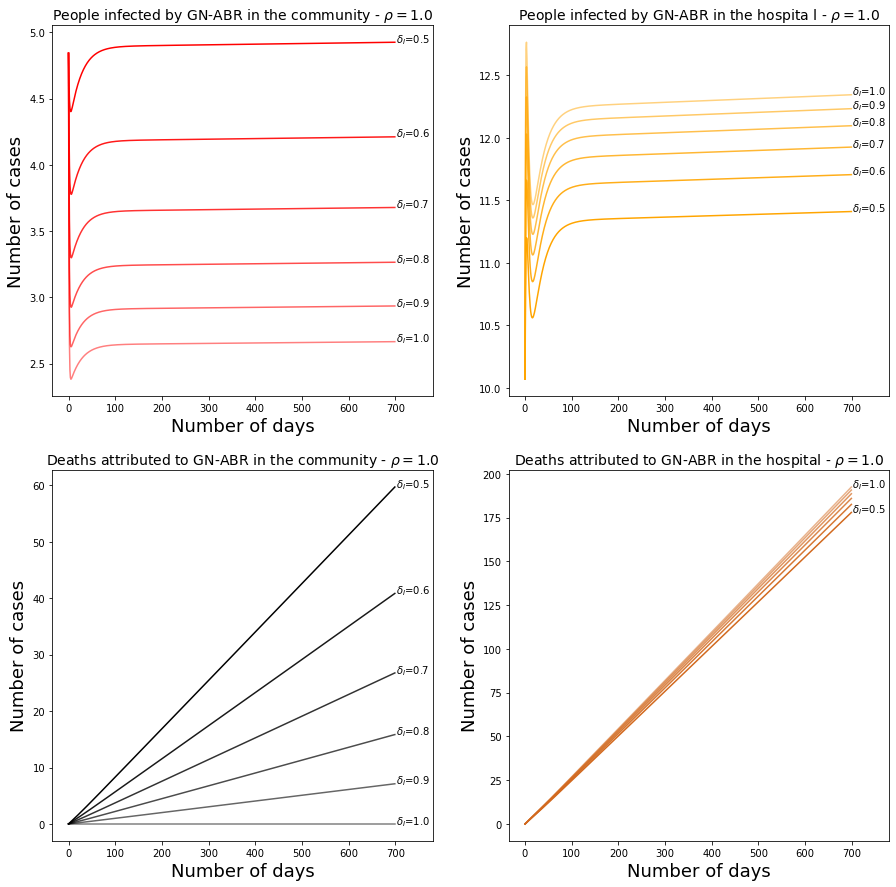

In [8]:
DELTA_I = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1])
RESULTS_deltaI_lowRisk = []

for i in range(len(DELTA_I)): 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho[0],delta,DELTA_I[i],epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_deltaI_lowRisk.append(solutions)

f, ax = plt.subplots(2,2, figsize=(15,15))

plt.subplot(2,2,1)
for i in range(len(DELTA_I)): #Community Infected
    plt.plot(RESULTS_deltaI_lowRisk[i][:,3],color = colors[compartment_names[3]],alpha=1.0-0.1*i) #label = r'$\delta_I$='+str(DELTA_I[i])
    plt.title(r'People infected by GN-ABR in the community - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    plt.text(tStop+0.5, RESULTS_deltaI_lowRisk[i][:,3][tStop-1],r'$\delta_I$='+str(DELTA_I[i]), fontsize = 10 )   
plt.xlim(right=tStop+80)


plt.subplot(2,2,2)
for i in range(len(DELTA_I)): #Hospital Infected
    plt.plot(RESULTS_deltaI_lowRisk[i][:,8], label = r'$\delta_I$='+str(DELTA_I[i]),color = colors[compartment_names[8]] ,alpha=1.0-0.1*i)
    plt.title(r'People infected by GN-ABR in the hospita l - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    plt.text(tStop+0.5, RESULTS_deltaI_lowRisk[i][:,8][tStop-1],r'$\delta_I$='+str(DELTA_I[i]), fontsize = 10 )
plt.xlim(right=tStop+80)


plt.subplot(2,2,3)
for i in range(len(DELTA_I)): #Removed in Community 
    plt.plot(RESULTS_deltaI_lowRisk[i][:,6], color = colors[compartment_names[6]] ,alpha=1.0-0.1*i)
    plt.title(r'Deaths attributed to GN-ABR in the community - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    plt.text(tStop+0.5, RESULTS_deltaI_lowRisk[i][:,6][tStop-1],r'$\delta_I$='+str(DELTA_I[i]), fontsize = 10 ) 
plt.xlim(right=tStop+80)


plt.subplot(2,2,4)
for i in range(len(DELTA_I)): #Romoved in Hospital
    plt.plot(RESULTS_deltaI_lowRisk[i][:,7], label = r'$\delta_I$='+str(DELTA_I[i]),color = colors[compartment_names[7]] ,alpha=1.0-0.1*i)
    plt.title(r'Deaths attributed to GN-ABR in the hospital - $\rho=$'+str(rho[0]), fontsize = 14 )
    plt.xlabel('Number of days', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    if i == 0 or i== len(DELTA_I)-1:
        plt.text(tStop+0.5, RESULTS_deltaI_lowRisk[i][:,7][tStop-1],r'$\delta_I$='+str(DELTA_I[i]), fontsize = 10 ) 
plt.xlim(right=tStop+80)

plt.savefig("HospitalisationRate_p_1.pdf", dpi=250)

#High-risk scenario

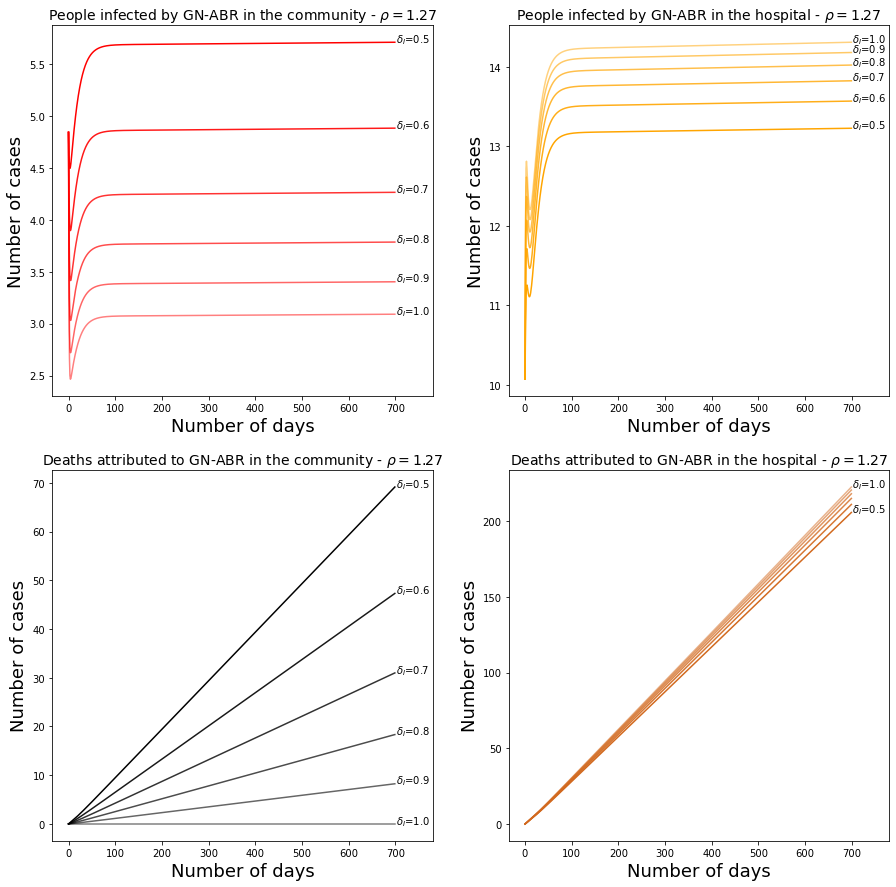

In [9]:
RESULTS_deltaI_highRisk = []

for i in range(len(DELTA_I)): 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho[1],delta,DELTA_I[i],epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_deltaI_highRisk.append(solutions)

f, ax = plt.subplots(2,2, figsize=(15,15))

plt.subplot(2,2,1)
for i in range(len(DELTA_I)): #Community Infected
    plt.plot(RESULTS_deltaI_highRisk[i][:,3],color = colors[compartment_names[3]],alpha=1.0-0.1*i) #label = r'$\delta_I$='+str(DELTA_I[i])
    plt.title(r'People infected by GN-ABR in the community - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    plt.text(tStop+0.5, RESULTS_deltaI_highRisk[i][:,3][tStop-1],r'$\delta_I$='+str(DELTA_I[i]), fontsize = 10 )   
plt.xlim(right=tStop+80)


plt.subplot(2,2,2)
for i in range(len(DELTA_I)): #Hospital Infected
    plt.plot(RESULTS_deltaI_highRisk[i][:,8], label = r'$\delta_I$='+str(DELTA_I[i]),color = colors[compartment_names[8]] ,alpha=1.0-0.1*i)
    plt.title(r'People infected by GN-ABR in the hospital - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    plt.text(tStop+0.5, RESULTS_deltaI_highRisk[i][:,8][tStop-1],r'$\delta_I$='+str(DELTA_I[i]), fontsize = 10 )
plt.xlim(right=tStop+80)


plt.subplot(2,2,3)
for i in range(len(DELTA_I)): #Removed in Community 
    plt.plot(RESULTS_deltaI_highRisk[i][:,6], color = colors[compartment_names[6]] ,alpha=1.0-0.1*i)
    plt.title(r'Deaths attributed to GN-ABR in the community - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    plt.text(tStop+0.5, RESULTS_deltaI_highRisk[i][:,6][tStop-1],r'$\delta_I$='+str(DELTA_I[i]), fontsize = 10 ) 
plt.xlim(right=tStop+80)


plt.subplot(2,2,4)
for i in range(len(DELTA_I)): #Romoved in Hospital
    plt.plot(RESULTS_deltaI_highRisk[i][:,7], label = r'$\delta_I$='+str(DELTA_I[i]),color = colors[compartment_names[7]] ,alpha=1.0-0.1*i)
    plt.title(r'Deaths attributed to GN-ABR in the hospital - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize=18)
    plt.ylabel('Number of cases', fontsize=18)
    if i == 0 or i== len(DELTA_I)-1:
        plt.text(tStop+0.5, RESULTS_deltaI_highRisk[i][:,7][tStop-1],r'$\delta_I$='+str(DELTA_I[i]), fontsize = 10 )
plt.xlim(right=tStop+80)

plt.savefig("HospitalisationRate_p_127.pdf", dpi=250)


Table of parameter variations

Average Variation in time:

Calculate the average for all times for the difference rate between the number of people in one compartment at a certain time in a certain scenario against the baseline scenario. 
For example:
Let I={0,1,2,3,4,..N} the set of the different N scenarios that represent different value for a certain variable of the model (e.g. the Hospitalization Rate for people with community-acquired BSI, δ_I) where 0 is the baseline scenario. And let  J={S,Z_C,Z_H,I_C,I_HH,I_HC,R_C,R_H} the set of the different compartments, and the T={1,…700} the days. Then, the AVIT value for que scenario i and compartment j will be:

AVIT_(i,j)   =((∑_(∀t∈T)▒((x_t^{i,j} -x_t^{0,j} )/(x_t^(0,j) )  ) ))/700            ∀i∈I,∀j∈J


Table Max 

Calculate the difference rate between the maximum value of number of people in one compartment of all the time series in a certain scenario against the baseline scenario. 
With the same definitions above:

MAX_(i,j)   =(max⁡〖〖{x〗_t^{i,j} }〗-max⁡〖〖{x〗_t^{0,j} }〗)/max⁡〖〖{x〗_t^{0,j} }〗             ∀i∈I,∀j∈J


In [10]:
# Varying the parameter

variations = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1])

#AVIT

#low risk
delta_I_low_risk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_deltaI_lowRisk,0.8,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#high risk
delta_I_high_risk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_deltaI_highRisk,0.8,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])

#MAX

#low risk
delta_I_low_risk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_deltaI_lowRisk,0.8,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#high risk
delta_I_high_risk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_deltaI_highRisk,0.8,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])


<ipython-input-2-b2ac5ab27d45>:117: RuntimeWarning: invalid value encountered in true_divide
  comparition = (compartment_i-compartment_baseline)/compartment_baseline


In [11]:
print(delta_I_low_risk_ct_avit)
print(delta_I_high_risk_ct_avit)

               0.5       0.6       0.7  0.8       0.9       1.0
$S$      -0.000013 -0.000008 -0.000003  0.0  0.000003  0.000005
$Z_C$    -0.000643 -0.000367 -0.000160  0.0  0.000128  0.000232
$Z_H$    -0.035414 -0.020184 -0.008814  0.0  0.007032  0.012773
$I_C$     0.507664  0.289437  0.126413  0.0 -0.100888 -0.183272
$I_{HC}$ -0.057294 -0.032666 -0.014268  0.0  0.011387  0.020686
$I_{HH}$ -0.035018 -0.019960 -0.008716  0.0  0.006954  0.012632
$R_C$     2.754193  1.572964  0.687916  0.0 -0.550081 -1.000000
$R_H$    -0.057824 -0.033036 -0.014452  0.0  0.011562  0.021022
$I_H$    -0.056502 -0.032213 -0.014069  0.0  0.011228  0.020396
               0.5       0.6       0.7  0.8       0.9       1.0
$S$      -0.000013 -0.000008 -0.000003  0.0  0.000003  0.000005
$Z_C$    -0.000644 -0.000367 -0.000160  0.0  0.000128  0.000233
$Z_H$    -0.035464 -0.020214 -0.008827  0.0  0.007043  0.012793
$I_C$     0.507483  0.289347  0.126379  0.0 -0.100866 -0.183235
$I_{HC}$ -0.057401 -0.032729 -0.014296  

In [12]:
print(delta_I_low_risk_ct_max)
print(delta_I_high_risk_ct_max)

               0.5       0.6       0.7  0.8       0.9       1.0
$S$       0.000000  0.000000  0.000000  0.0  0.000000  0.000000
$Z_C$    -0.001280 -0.000730 -0.000319  0.0  0.000254  0.000462
$Z_H$     0.000000  0.000000  0.000000  0.0  0.000000  0.000000
$I_C$     0.017143  0.000000  0.000000  0.0  0.000000  0.000000
$I_{HC}$ -0.057357 -0.032699 -0.014281  0.0  0.011397  0.020703
$I_{HH}$ -0.000669 -0.000427 -0.000204  0.0  0.000188  0.000362
$R_C$     2.769721  1.579138  0.689710  0.0 -0.550470 -1.000000
$R_H$    -0.056558 -0.032246 -0.014084  0.0  0.011241  0.020420
$I_H$    -0.074332 -0.050398 -0.024065  0.0  0.019527  0.035500
               0.5       0.6       0.7  0.8       0.9       1.0
$S$       0.000000  0.000000  0.000000  0.0  0.000000  0.000000
$Z_C$    -0.001281 -0.000731 -0.000319  0.0  0.000255  0.000463
$Z_H$     0.000000  0.000000  0.000000  0.0  0.000000  0.000000
$I_C$     0.179204  0.008378  0.000000  0.0  0.000000  0.000000
$I_{HC}$ -0.057357 -0.032699 -0.014281  

# 2.Probability of a bacterial resistant infection; number of people infected

#Low-risk scenario

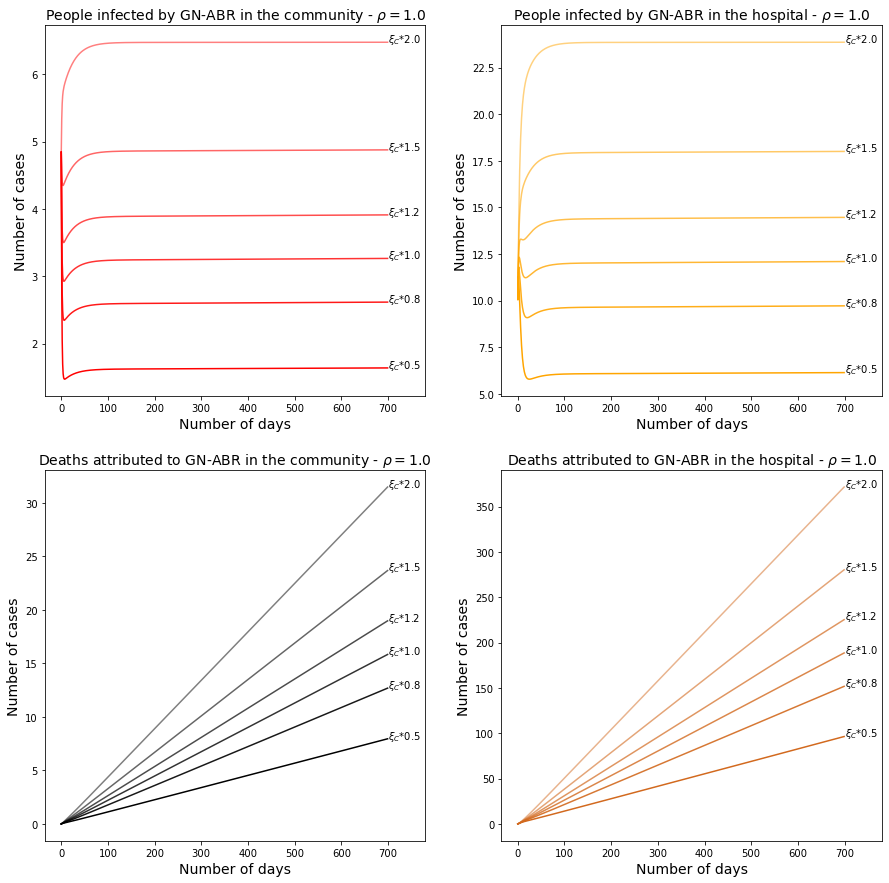

In [7]:
variation_XI_C = np.array([0.5,0.8,1,1.2,1.5,2])
XI_C = xi_C*variation_XI_C
RESULTS_XI_C_lowRisk = []

for i in range(len(XI_C)): 
    parameters = Lambda,phi,XI_C[i],xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho[0],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_XI_C_lowRisk.append(solutions)    
       
f, ax = plt.subplots(2,2, figsize=(15,15))



plt.subplot(2,2,1)
for i in range(len(variation_XI_C)): #Community Infected
    plt.plot(RESULTS_XI_C_lowRisk[i][:,3], color = colors[compartment_names[3]],alpha=1.0-0.1*i)
    plt.title(r'People infected by GN-ABR in the community - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_C_lowRisk[i][:,3][tStop-1],r'$\xi_C$*'+str(variation_XI_C[i]), fontsize = 10 ) 
plt.xlim(right=tStop+80)


plt.subplot(2,2,2)
for i in range(len(variation_XI_C)): #Hospital Infected
    plt.plot(RESULTS_XI_C_lowRisk[i][:,8], color = colors[compartment_names[8]],alpha=1.0-0.1*i)
    plt.title(r'People infected by GN-ABR in the hospital - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_C_lowRisk[i][:,8][tStop-1],r'$\xi_C$*'+str(variation_XI_C[i]), fontsize = 10 )
plt.xlim(right=tStop+80)

plt.subplot(2,2,3)
for i in range(len(variation_XI_C)): #Deaths in Community 
    plt.plot(RESULTS_XI_C_lowRisk[i][:,6], color = colors[compartment_names[6]],alpha=1.0-0.1*i)
    plt.title(r'Deaths attributed to GN-ABR in the community - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_C_lowRisk[i][:,6][tStop-1],r'$\xi_C$*'+str(variation_XI_C[i]), fontsize = 10 )
plt.xlim(right=tStop+80)

plt.subplot(2,2,4)
for i in range(len(variation_XI_C)): #Deaths in Hospital
    plt.plot(RESULTS_XI_C_lowRisk[i][:,7], color = colors[compartment_names[7]],alpha=1.0-0.1*i)
    plt.title(r'Deaths attributed to GN-ABR in the hospital - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_C_lowRisk[i][:,7][tStop-1],r'$\xi_C$*'+str(variation_XI_C[i]), fontsize = 10 )
plt.xlim(right=tStop+80)

plt.savefig("Probinfection_p_1.pdf", dpi=250)

#High-risk scenario

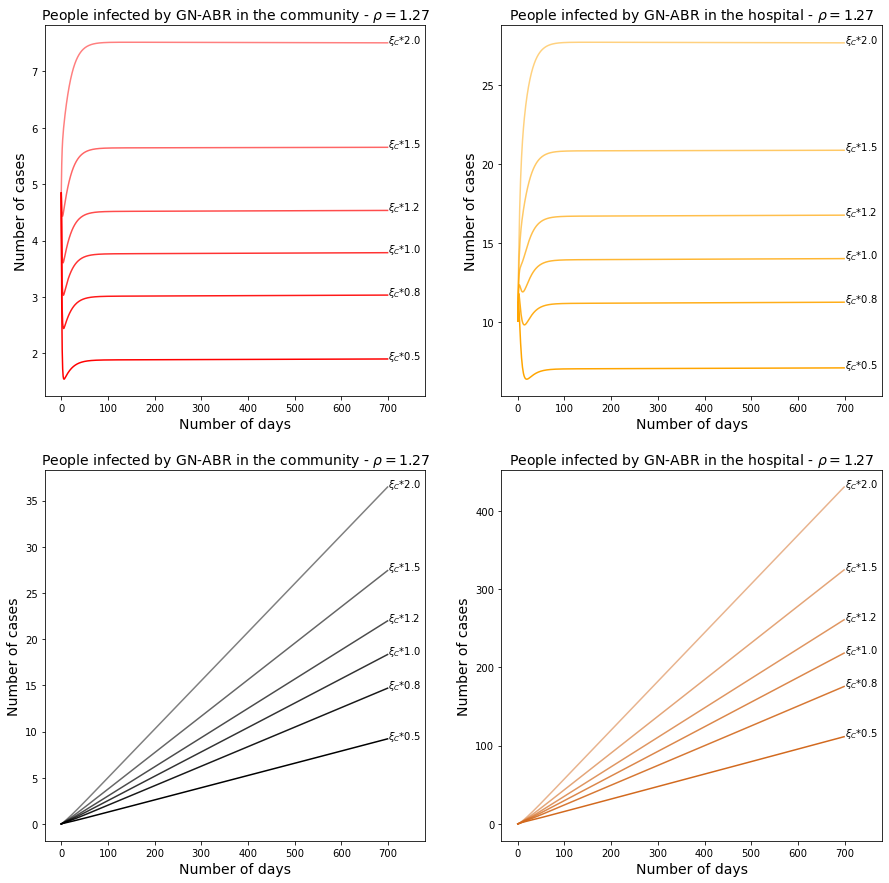

In [5]:
variation_XI_C = np.array([0.5,0.8,1,1.2,1.5,2])
XI_C = xi_C*variation_XI_C
RESULTS_XI_C_highRisk = []

for i in range(len(XI_C)): 
    parameters = Lambda,phi,XI_C[i],xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho[1],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_XI_C_highRisk.append(solutions)    
    
    
    
f, ax = plt.subplots(2,2, figsize=(15,15))

plt.subplot(2,2,1)
for i in range(len(variation_XI_C)): #Community Infected
    plt.plot(RESULTS_XI_C_highRisk[i][:,3], color = colors[compartment_names[3]],alpha=1.0-0.1*i)
    plt.title(r'People infected by GN-ABR in the community - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_C_highRisk[i][:,3][tStop-1],r'$\xi_C$*'+str(variation_XI_C[i]), fontsize = 10 ) 
plt.xlim(right=tStop+80)


plt.subplot(2,2,2)
for i in range(len(variation_XI_C)): #Hospital Infected
    plt.plot(RESULTS_XI_C_highRisk[i][:,8], color = colors[compartment_names[8]],alpha=1.0-0.1*i)
    plt.title(r'People infected by GN-ABR in the hospital - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_C_highRisk[i][:,8][tStop-1],r'$\xi_C$*'+str(variation_XI_C[i]), fontsize = 10 )
plt.xlim(right=tStop+80)

plt.subplot(2,2,3)
for i in range(len(variation_XI_C)): #Deaths in Community 
    plt.plot(RESULTS_XI_C_highRisk[i][:,6], color = colors[compartment_names[6]],alpha=1.0-0.1*i)
    plt.title(r'People infected by GN-ABR in the community - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_C_highRisk[i][:,6][tStop-1],r'$\xi_C$*'+str(variation_XI_C[i]), fontsize = 10 )
plt.xlim(right=tStop+80)

plt.subplot(2,2,4)
for i in range(len(variation_XI_C)): #Deaths in Hospital
    plt.plot(RESULTS_XI_C_highRisk[i][:,7], color = colors[compartment_names[7]],alpha=1.0-0.1*i)
    plt.title(r'People infected by GN-ABR in the hospital - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_C_highRisk[i][:,7][tStop-1],r'$\xi_C$*'+str(variation_XI_C[i]), fontsize = 10)
plt.xlim(right=tStop+80)

plt.savefig("Probinfection_p_127.pdf", dpi=250)

Table of parameter variations

In [18]:
# Varying the parameter
variations = XI_C

#AVIT
#Low risk
RESULTS_XI_C_lowRisk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_XI_C_lowRisk,xi_C,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#High risk
RESULTS_XI_C_highRisk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_XI_C_highRisk,xi_C,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])

#MAX
#Low risk
RESULTS_XI_C_lowRisk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_XI_C_lowRisk,xi_C,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#High risk
RESULTS_XI_C_highRisk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_XI_C_highRisk,xi_C,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])

<ipython-input-2-b2ac5ab27d45>:117: RuntimeWarning: invalid value encountered in true_divide
  comparition = (compartment_i-compartment_baseline)/compartment_baseline


In [25]:
print(RESULTS_XI_C_lowRisk_ct_avit)
print(RESULTS_XI_C_highRisk_ct_avit)

          0.00011   0.00110    0.01100     0.05500
$S$           0.0  0.002218   0.024563    0.125570
$Z_C$         0.0 -0.041658  -0.345102   -0.777392
$Z_H$         0.0  5.246257  39.468200   67.178896
$I_C$         0.0  8.558404  64.293019  109.656929
$I_{HC}$      0.0  8.509611  64.054961  109.744060
$I_{HH}$      0.0  5.195751  39.107921   66.359014
$R_C$         0.0  8.608443  75.306626  190.094390
$R_H$         0.0  8.220772  71.772186  179.642097
$I_H$         0.0  8.404153  63.238441  108.122065
          0.00011   0.00110    0.01100     0.05500
$S$           0.0  0.002263   0.025102    0.129793
$Z_C$         0.0 -0.041052  -0.340415   -0.768487
$Z_H$         0.0  5.249571  39.752390   69.914055
$I_C$         0.0  8.564568  64.762372  114.111696
$I_{HC}$      0.0  8.516735  64.531873  114.219865
$I_{HH}$      0.0  5.200235  39.402876   69.134278
$R_C$         0.0  8.623444  75.785174  194.761864
$R_H$         0.0  8.258489  72.452546  184.827681
$I_H$         0.0  8.411529  63

In [26]:
print(RESULTS_XI_C_lowRisk_ct_max)
print(RESULTS_XI_C_highRisk_ct_max)

          0.00011   0.00110    0.01100     0.05500
$S$           0.0  0.000000   0.000000    0.000000
$Z_C$         0.0 -0.026706  -0.130325   -0.130325
$Z_H$         0.0  0.000000   4.390742   18.148057
$I_C$         0.0  5.563980  56.383529  248.700850
$I_{HC}$      0.0  8.733140  84.050777  307.690701
$I_{HH}$      0.0  0.167269   8.667476   32.564134
$R_C$         0.0  8.560642  64.212285  108.823149
$R_H$         0.0  8.410473  63.202627  107.472905
$I_H$         0.0  8.455577  81.535598  297.087020
          0.00011   0.00110    0.01100     0.05500
$S$           0.0  0.000000   0.000000    0.000000
$Z_C$         0.0 -0.022484  -0.143903   -0.249844
$Z_H$         0.0  0.000000   5.286287   19.940041
$I_C$         0.0  6.642778  65.932294  255.732523
$I_{HC}$      0.0  8.774892  84.552131  286.639860
$I_{HH}$      0.0  0.358949  10.273002   36.272620
$R_C$         0.0  8.569021  64.654072  112.823934
$R_H$         0.0  8.426381  63.695417  111.524232
$I_H$         0.0  8.676672  83

# 3. Antibiotic Consumption in the Hospital

#Low-risk scenario

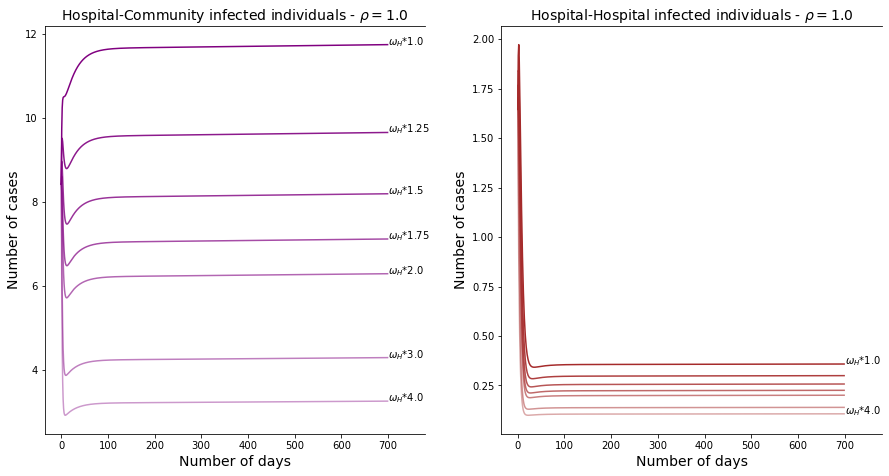

In [9]:
variation = np.array([1, 1.25, 1.5, 1.75, 2, 3, 4]) 
OMEGA_H = omega_H*variation
RESULTS_OMEGA_H_lowRisk = []

for i in range(len(OMEGA_H)): 
    parameters = parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,OMEGA_H[i],omega_C,eta,rho[0],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_OMEGA_H_lowRisk.append(solutions)    
    

f, ax = plt.subplots(1,2, figsize=(15,7.5))
  

plt.subplot(1,2,1)  
for i in range(len(variation)): #Hospital-Community
    plt.plot(RESULTS_OMEGA_H_lowRisk[i][:,4], color = colors[compartment_names[4]],alpha=1.0-0.1*i)
    plt.title(r'Hospital-Community infected individuals - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_OMEGA_H_lowRisk[i][:,4][tStop-1],r'$\omega_H$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80) 

plt.subplot(1,2,2)  
for i in range(len(variation)): #Hospital-Hospital
    plt.plot(RESULTS_OMEGA_H_lowRisk[i][:,5], color = colors[compartment_names[5]],alpha=1.0-0.1*i)
    plt.title(r'Hospital-Hospital infected individuals - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    if i==0 or i==len(variation)-1:
        plt.text(tStop+0.5, RESULTS_OMEGA_H_lowRisk[i][:,5][tStop-1],r'$\omega_H$*'+str(variation[i]), fontsize = 10 )
        plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80) 

plt.savefig("ATBconsHospital_p_1.pdf", dpi=250)

#High-risk scenario

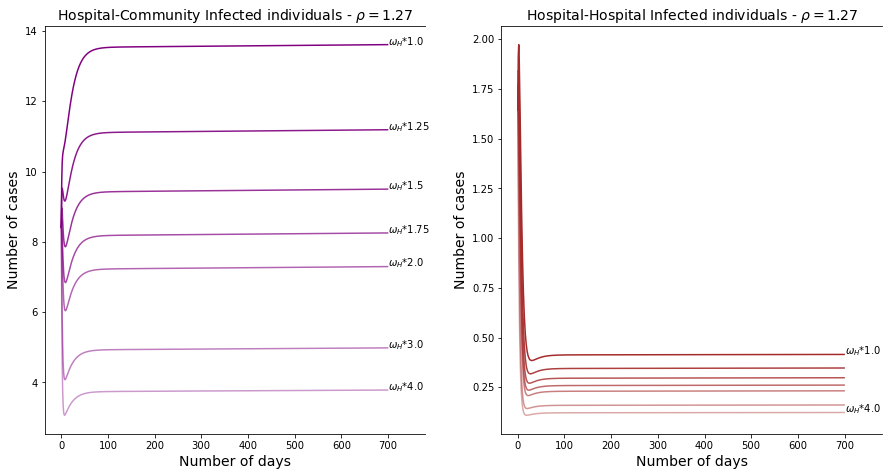

In [10]:
variation = np.array([1, 1.25, 1.5, 1.75, 2, 3, 4]) 
OMEGA_H = omega_H*variation
RESULTS_OMEGA_H_highRisk = []

for i in range(len(OMEGA_H)): 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,OMEGA_H[i],omega_C,eta,rho[1],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_OMEGA_H_highRisk.append(solutions)    
    

f, ax = plt.subplots(1,2, figsize=(15,7.5))
  
plt.subplot(1,2,1)  
for i in range(len(variation)): #Hospital-Community
    plt.plot(RESULTS_OMEGA_H_highRisk[i][:,4], color = colors[compartment_names[4]],alpha=1.0-0.1*i)
    plt.title(r'Hospital-Community Infected individuals - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_OMEGA_H_highRisk[i][:,4][tStop-1],r'$\omega_H$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80) 

plt.subplot(1,2,2)  
for i in range(len(variation)): #Hospital-Hospital
    plt.plot(RESULTS_OMEGA_H_highRisk[i][:,5], color = colors[compartment_names[5]],alpha=1.0-0.1*i)
    plt.title(r'Hospital-Hospital Infected individuals - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    if i==0 or i==len(variation)-1:
        plt.text(tStop+0.5, RESULTS_OMEGA_H_highRisk[i][:,5][tStop-1],r'$\omega_H$*'+str(variation[i]), fontsize = 10 )
plt.xlim(right=tStop+80)
plt.gca().spines['right'].set_visible(False)
plt.savefig("ATBconsHospital_p_127.pdf", dpi=250)

Table of parameter variations

In [25]:
# Tablas de variaciones
variations = OMEGA_H

#AVIT
#Low risk
RESULTS_OMEGA_H_lowRisk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_OMEGA_H_lowRisk,omega_H,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#High risk
RESULTS_OMEGA_H_highRisk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_OMEGA_H_highRisk,omega_H,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])

#MAX
#Low risk
RESULTS_OMEGA_H_lowRisk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_OMEGA_H_lowRisk,omega_H,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#High risk
RESULTS_OMEGA_H_highRisk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_OMEGA_H_highRisk,omega_H,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])

<ipython-input-2-b2ac5ab27d45>:117: RuntimeWarning: invalid value encountered in true_divide
  comparition = (compartment_i-compartment_baseline)/compartment_baseline


In [26]:
print(RESULTS_OMEGA_H_lowRisk_ct_avit)
print(RESULTS_OMEGA_H_highRisk_ct_avit)

          0.20      0.25      0.30      0.35      0.40      0.60      0.80
$S$        0.0  0.000006  0.000010  0.000013  0.000015  0.000021  0.000024
$Z_C$      0.0  0.000888  0.001509  0.001968  0.002321  0.003177  0.003621
$Z_H$      0.0  0.017756  0.030114  0.039208  0.046177  0.062952  0.071619
$I_C$      0.0  0.000885  0.001504  0.001962  0.002314  0.003166  0.003610
$I_{HC}$   0.0 -0.177320 -0.301183 -0.392595 -0.462833 -0.632595 -0.720709
$I_{HH}$   0.0 -0.165745 -0.284522 -0.373740 -0.443184 -0.614222 -0.704784
$R_C$      0.0  0.000472  0.000804  0.001049  0.001239  0.001699  0.001939
$R_H$      0.0 -0.224694 -0.382969 -0.500528 -0.591316 -0.812563 -0.928543
$I_H$      0.0 -0.177018 -0.300754 -0.392115 -0.462338 -0.632143 -0.720321
          0.20      0.25      0.30      0.35      0.40      0.60      0.80
$S$        0.0  0.000006  0.000010  0.000012  0.000015  0.000020  0.000022
$Z_C$      0.0  0.000884  0.001503  0.001961  0.002313  0.003165  0.003608
$Z_H$      0.0  0.017842 

In [31]:
print(RESULTS_OMEGA_H_lowRisk_ct_max)
print(RESULTS_OMEGA_H_highRisk_ct_max)

          0.20      0.25      0.30      0.35      0.40      0.60      0.80
$S$        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
$Z_C$      0.0  0.001715  0.002914  0.003799  0.004480  0.006125  0.006980
$Z_H$      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
$I_C$      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
$I_{HC}$   0.0 -0.177855 -0.236335 -0.266806 -0.282406 -0.282406 -0.282406
$I_{HH}$   0.0 -0.066528 -0.103140 -0.138137 -0.165659 -0.165659 -0.165659
$R_C$      0.0  0.000888  0.001510  0.001970  0.002324  0.003180  0.003625
$R_H$      0.0 -0.228594 -0.388379 -0.506360 -0.597045 -0.816345 -0.930240
$I_H$      0.0 -0.079486 -0.129232 -0.163851 -0.183112 -0.183112 -0.183112
          0.20      0.25      0.30      0.35      0.40      0.60      0.80
$S$        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
$Z_C$      0.0  0.001713  0.002910  0.003794  0.004474  0.006117  0.006971
$Z_H$      0.0  0.000000 

# 4. Probability of BSI at hospital

#low-risk scenario

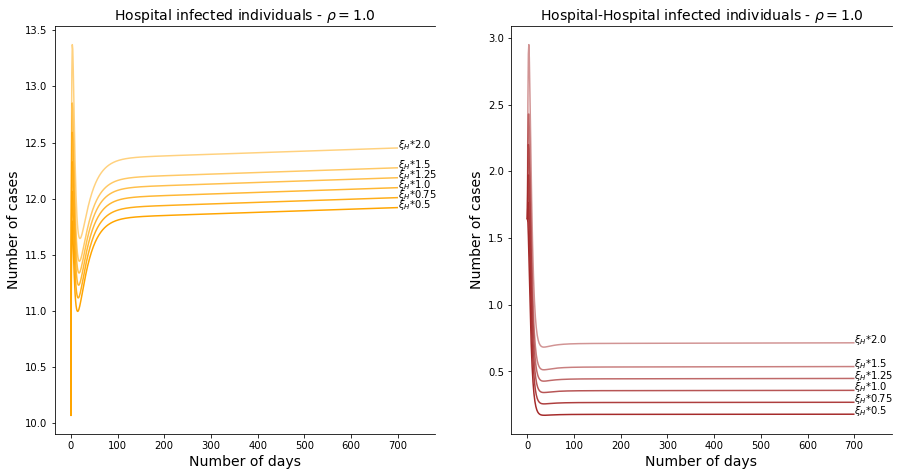

In [18]:
variation = np.array([0.5, 0.75, 1, 1.25, 1.5, 2]) 
XI_H = xi_H*variation
RESULTS_XI_H_lowRisk = []

for i in range(len(XI_H)): 
    parameters = Lambda,phi,xi_C,XI_H[i],V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho[0],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_XI_H_lowRisk.append(solutions)    


f, ax = plt.subplots(1,2, figsize=(15,7.5))    



plt.subplot(1,2,1)
for i in range(len(variation)): #Hospital 
    plt.plot(RESULTS_XI_H_lowRisk[i][:,8], color = colors[compartment_names[8]],alpha=1.0-0.1*i)
    plt.title(r'Hospital infected individuals - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_H_lowRisk[i][:,8][tStop-1],r'$\xi_H$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80) 



plt.subplot(1,2,2)
for i in range(len(variation)): #Hospital-Hospital
    plt.plot(RESULTS_XI_H_lowRisk[i][:,5], color = colors[compartment_names[5]],alpha=1.0-0.1*i)
    plt.title(r'Hospital-Hospital infected individuals - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_H_lowRisk[i][:,5][tStop-1],r'$\xi_H$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)
plt.savefig("ProbBSIhosp_p_1.pdf", dpi=250)
 

#High-risk scenario

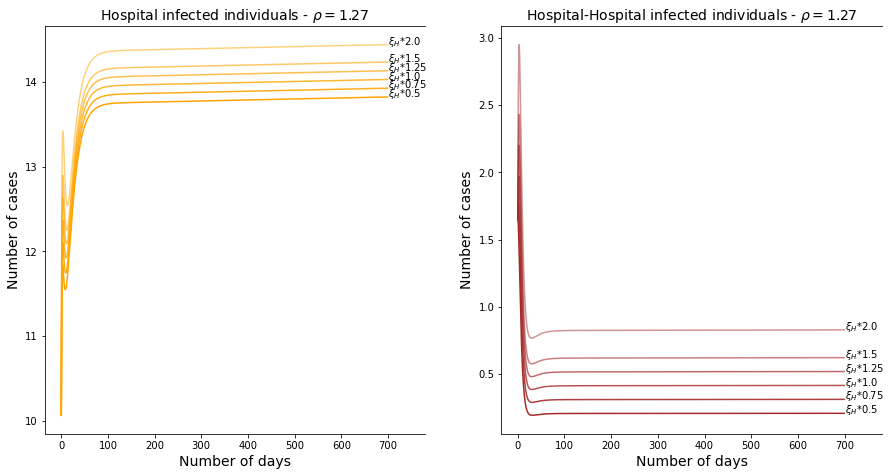

In [20]:
variation = np.array([0.5, 0.75, 1, 1.25, 1.5, 2]) 
XI_H = xi_H*variation
RESULTS_XI_H_highRisk = []

for i in range(len(XI_H)): 
    parameters = Lambda,phi,xi_C,XI_H[i],V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,rho[1],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_XI_H_highRisk.append(solutions)    


f, ax = plt.subplots(1,2, figsize=(15,7.5))    


plt.subplot(1,2,1)
for i in range(len(variation)): #Hospital 
    plt.plot(RESULTS_XI_H_highRisk[i][:,8], color = colors[compartment_names[8]],alpha=1.0-0.1*i)
    plt.title(r'Hospital infected individuals - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_H_highRisk[i][:,8][tStop-1],r'$\xi_H$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80) 



plt.subplot(1,2,2)
for i in range(len(variation)): #Hospital-Hospital
    plt.plot(RESULTS_XI_H_highRisk[i][:,5], color = colors[compartment_names[5]],alpha=1.0-0.1*i)
    plt.title(r'Hospital-Hospital infected individuals - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_XI_H_highRisk[i][:,5][tStop-1],r'$\xi_H$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
    plt.xlim(right=tStop+80)

plt.savefig("ProbBSIhosp_p_127.pdf", dpi=250)

Table of parameter variations

In [34]:
# Varying the parameter
variations = XI_H


#AVIT
#Low-risk
RESULTS_XI_H_lowRisk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_XI_H_lowRisk,xi_H,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#High risk
RESULTS_XI_H_highRisk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_XI_H_highRisk,xi_H,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])

#MAX
#Low risk
RESULTS_XI_H_lowRisk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_XI_H_lowRisk,xi_H,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#Low risk
RESULTS_XI_H_highRisk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_XI_H_highRisk,xi_H,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])


/Users/danieltoro/anaconda3/envs/AMR/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide


In [35]:
print(RESULTS_XI_H_lowRisk_ct_avit)
print(RESULTS_XI_H_highRisk_ct_avit)

          0.0110        0.0165    0.0330    0.0550    0.1100
$S$          0.0 -3.489836e-07 -0.000001 -0.000003 -0.000006
$Z_C$        0.0 -6.202828e-05 -0.000247 -0.000492 -0.001094
$Z_H$        0.0 -1.082397e-03 -0.004319 -0.008609 -0.019210
$I_C$        0.0 -6.183570e-05 -0.000246 -0.000491 -0.001090
$I_{HC}$     0.0 -6.110533e-05 -0.000244 -0.000485 -0.001078
$I_{HH}$     0.0  4.941603e-01  1.970099  3.922869  8.730298
$R_C$        0.0 -3.591745e-05 -0.000143 -0.000285 -0.000632
$R_H$        0.0  1.675530e-02  0.066738  0.132727  0.294516
$I_H$        0.0  1.510574e-02  0.060210  0.119857  0.266560
          0.0110        0.0165    0.0330    0.0550    0.1100
$S$          0.0 -2.830682e-07 -0.000001 -0.000002 -0.000005
$Z_C$        0.0 -6.129552e-05 -0.000244 -0.000486 -0.001081
$Z_H$        0.0 -1.095217e-03 -0.004370 -0.008709 -0.019428
$I_C$        0.0 -6.110439e-05 -0.000244 -0.000485 -0.001078
$I_{HC}$     0.0 -6.038150e-05 -0.000241 -0.000479 -0.001065
$I_{HH}$     0.0  4.9417

In [36]:
print(RESULTS_XI_H_lowRisk_ct_max)
print(RESULTS_XI_H_highRisk_ct_max)

          0.0110    0.0165    0.0330    0.0550    0.1100
$S$          0.0  0.000000  0.000000  0.000000  0.000000
$Z_C$        0.0 -0.000115 -0.000457 -0.000911 -0.002025
$Z_H$        0.0  0.000000  0.000000  0.000000  0.000000
$I_C$        0.0  0.000000  0.000000  0.000000  0.000000
$I_{HC}$     0.0 -0.000114 -0.000454 -0.000904 -0.002010
$I_{HH}$     0.0  0.231617  1.016044  2.033056  4.470665
$R_C$        0.0 -0.000062 -0.000247 -0.000492 -0.001094
$R_H$        0.0  0.015114  0.060241  0.119918  0.266690
$I_H$        0.0  0.042524  0.168062  0.334201  0.725697
          0.0110    0.0165    0.0330    0.0550    0.1100
$S$          0.0  0.000000  0.000000  0.000000  0.000000
$Z_C$        0.0 -0.000114 -0.000455 -0.000905 -0.002014
$Z_H$        0.0  0.000000  0.000000  0.000000  0.000000
$I_C$        0.0  0.000000  0.000000  0.000000  0.000000
$I_{HC}$     0.0 -0.000113 -0.000451 -0.000899 -0.001998
$I_{HH}$     0.0  0.231786  1.016403  2.033664  4.473593
$R_C$        0.0 -0.000061 -0.0

# 5. Spontaneus Clearence of Colonization

#Low-risk scenario

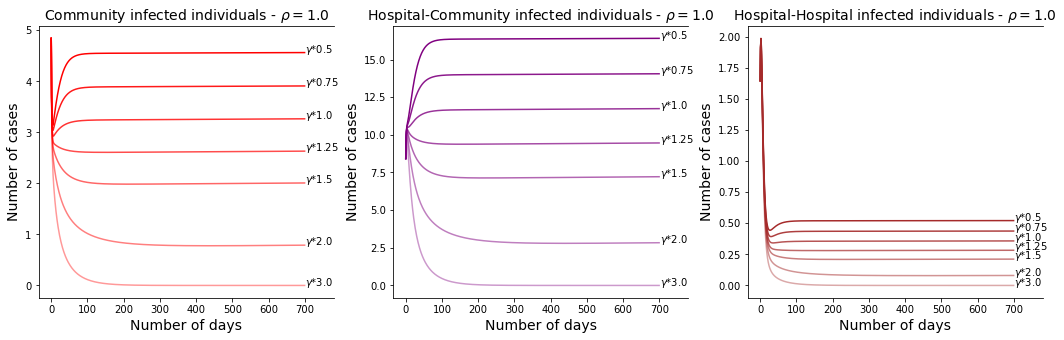

In [22]:
variation = np.array([0.5,0.75,1,1.25, 1.5, 2,3]) 
GAMMA = gamma*variation
RESULTS_GAMMA_lowRisk = []

for i in range(len(GAMMA)): 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,GAMMA[i],beta_H,beta_C,omega_H,omega_C,eta,rho[0],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_GAMMA_lowRisk.append(solutions)  
    
f, ax = plt.subplots(1,3, figsize=(18,5))



plt.subplot(1,3,1)
for i in range(len(variation)): #Community    
    plt.plot(RESULTS_GAMMA_lowRisk[i][:,3], color = colors[compartment_names[3]],alpha=1.0-0.1*i)
    plt.title(r'Community infected individuals - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14 )
    plt.ylabel('Number of cases', fontsize = 14 )
    plt.text(tStop+0.5, RESULTS_GAMMA_lowRisk[i][:,3][tStop-1],r'$\gamma$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)

 
plt.subplot(1,3,2)
for i in range(len(variation)): #Hospital-Community
    plt.plot(RESULTS_GAMMA_lowRisk[i][:,4], color = colors[compartment_names[4]],alpha=1.0-0.1*i)
    plt.title(r'Hospital-Community infected individuals - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14 )
    plt.ylabel('Number of cases', fontsize = 14 )
    plt.text(tStop+0.5, RESULTS_GAMMA_lowRisk[i][:,4][tStop-1],r'$\gamma$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)

plt.subplot(1,3,3)
for i in range(len(variation)): #Hospital-Hospital
    plt.plot(RESULTS_GAMMA_lowRisk[i][:,5], color = colors[compartment_names[5]],alpha=1.0-0.1*i)
    plt.title(r'Hospital-Hospital infected individuals - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14 )
    plt.ylabel('Number of cases', fontsize = 14 )
    plt.text(tStop+0.5, RESULTS_GAMMA_lowRisk[i][:,5][tStop-1],r'$\gamma$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)

plt.savefig("SpontClear_p_1.pdf", dpi=250)


Escenario de alto riesgo

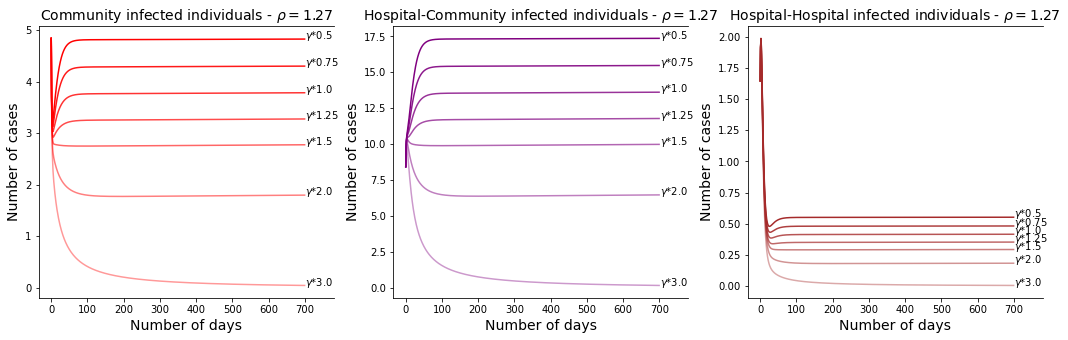

In [23]:
variation = np.array([0.5,0.75,1,1.25, 1.5, 2,3]) 
GAMMA = gamma*variation
RESULTS_GAMMA_highRisk = []

for i in range(len(GAMMA)): 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,GAMMA[i],beta_H,beta_C,omega_H,omega_C,eta,rho[1],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_GAMMA_highRisk.append(solutions)  
    
f, ax = plt.subplots(1,3, figsize=(18,5))



plt.subplot(1,3,1)
for i in range(len(variation)): #Community    
    plt.plot(RESULTS_GAMMA_highRisk[i][:,3], color = colors[compartment_names[3]],alpha=1.0-0.1*i)
    plt.title(r'Community infected individuals - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5,RESULTS_GAMMA_highRisk[i][:,3][tStop-1],r'$\gamma$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)

 
plt.subplot(1,3,2)
for i in range(len(variation)): #Hospital-Community
    plt.plot(RESULTS_GAMMA_highRisk[i][:,4], color = colors[compartment_names[4]],alpha=1.0-0.1*i)
    plt.title(r'Hospital-Community infected individuals - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_GAMMA_highRisk[i][:,4][tStop-1],r'$\gamma$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)

plt.subplot(1,3,3)
for i in range(len(variation)): #Hospital-Hospital
    plt.plot(RESULTS_GAMMA_highRisk[i][:,5], color = colors[compartment_names[5]],alpha=1.0-0.1*i)
    plt.title(r'Hospital-Hospital infected individuals - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_GAMMA_highRisk[i][:,5][tStop-1],r'$\gamma$*'+str(variation[i]), fontsize = 10 )
plt.xlim(right=tStop+80)
plt.gca().spines['right'].set_visible(False)
plt.savefig("SpontClear_p_127.pdf", dpi=250)

Table of parameter variations

In [50]:
# Varying the parameter
variations = GAMMA

#AVIT
#low risk
RESULTS_GAMMA_lowRisk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_GAMMA_lowRisk,gamma,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#high risk
RESULTS_GAMMA_highRisk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_GAMMA_highRisk,gamma,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])

#MAX
#low risk 
RESULTS_GAMMA_lowRisk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_GAMMA_lowRisk,gamma,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#high risk
RESULTS_GAMMA_highRisk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_GAMMA_highRisk,gamma,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])

<ipython-input-2-b2ac5ab27d45>:117: RuntimeWarning: invalid value encountered in true_divide
  comparition = (compartment_i-compartment_baseline)/compartment_baseline


In [40]:
print(RESULTS_GAMMA_lowRisk_ct_avit)
print(RESULTS_GAMMA_highRisk_ct_avit)

           0.00825   0.01650   0.02475  0.03300   0.06600   0.09900   0.13200
$S$      -0.727086 -0.483852 -0.241398      0.0  0.935769  1.271077  1.290722
$Z_C$     0.551741  0.367138  0.183153      0.0 -0.709611 -0.964744 -0.980635
$Z_H$     0.688846  0.445290  0.215937      0.0 -0.733777 -0.964106 -0.979013
$I_C$     0.590415  0.389776  0.192905      0.0 -0.718204 -0.965377 -0.980793
$I_{HC}$  0.586611  0.387259  0.191656      0.0 -0.713392 -0.959054 -0.974497
$I_{HH}$  0.683102  0.441585  0.214143      0.0 -0.727622 -0.955721 -0.970102
$R_C$     0.543435  0.357268  0.175967      0.0 -0.625926 -0.873580 -0.917662
$R_H$     0.531333  0.349112  0.171858      0.0 -0.609991 -0.850133 -0.892190
$I_H$     0.589431  0.388844  0.192311      0.0 -0.713775 -0.958888 -0.974278
           0.00825   0.01650   0.02475  0.03300   0.06600   0.09900   0.13200
$S$      -0.730446 -0.486530 -0.243013      0.0  0.962635  1.798342  1.890487
$Z_C$     0.377471  0.251393  0.125551      0.0 -0.496958 -0.928

In [41]:
print(RESULTS_GAMMA_lowRisk_ct_max)
print(RESULTS_GAMMA_highRisk_ct_max)

           0.00825   0.01650   0.02475  0.03300   0.06600   0.09900   0.13200
$S$       0.000000  0.000000  0.000000      0.0  0.729223  1.017909  1.018044
$Z_C$     0.560957  0.374023  0.187041      0.0 -0.130325 -0.130325 -0.130325
$Z_H$     0.000000  0.000000  0.000000      0.0  0.000000  0.000000  0.000000
$I_C$     0.079665  0.000000  0.000000      0.0  0.000000  0.000000  0.000000
$I_{HC}$  0.600986  0.397519  0.197193      0.0 -0.133345 -0.147565 -0.156783
$I_{HH}$  0.011149  0.007393  0.003676      0.0 -0.014318 -0.028038 -0.041189
$R_C$     0.591406  0.390455  0.193254      0.0 -0.719789 -0.967080 -0.982040
$R_H$     0.590505  0.389575  0.192684      0.0 -0.715442 -0.960751 -0.975757
$I_H$     0.574141  0.373159  0.175571      0.0 -0.021313 -0.032678 -0.043561
           0.00825   0.01650   0.02475  0.03300   0.06600   0.09900   0.13200
$S$       0.000000  0.000000  0.000000      0.0  0.360624  1.000915  1.018001
$Z_C$     0.380846  0.253925  0.126977      0.0 -0.249844 -0.249

# 6. Transmission Parameter in community

#Low-risk scenario

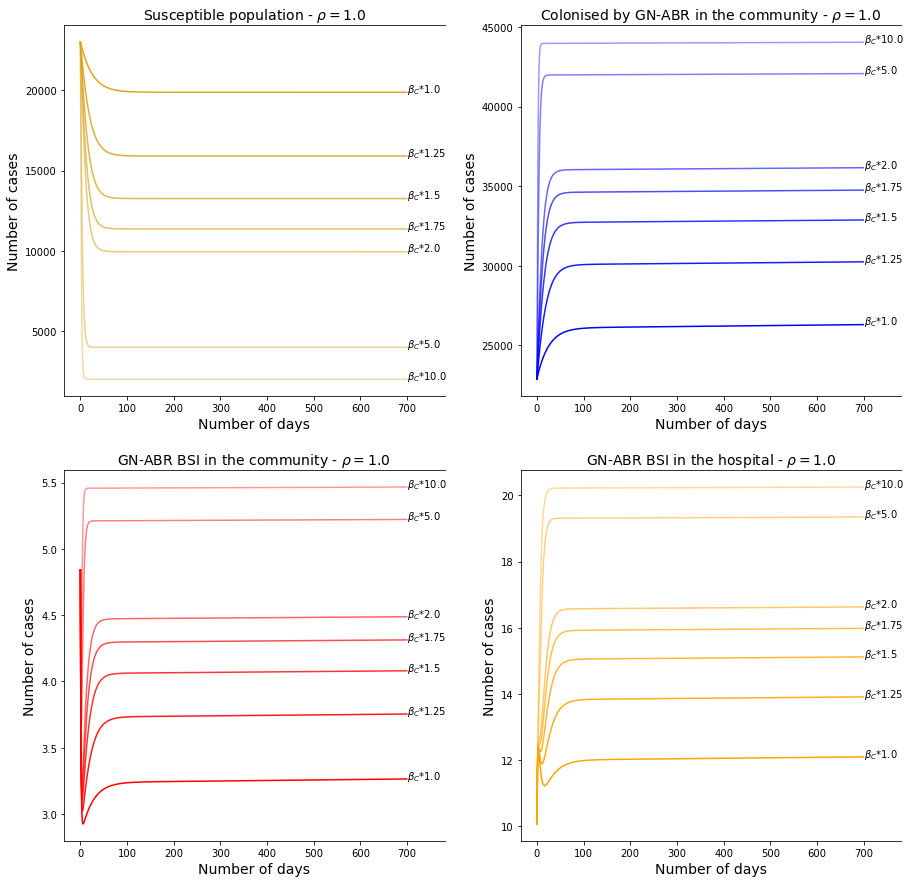

In [52]:
variation = np.array([1, 1.25, 1.5, 1.75, 2, 5, 10]) 
BETA_C = beta_C*variation
RESULTS_BETA_C_lowRisk = []

for i in range(len(BETA_C)): 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,BETA_C[i],omega_H,omega_C,eta,rho[0],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_BETA_C_lowRisk.append(solutions)
    
f, ax = plt.subplots(2,2, figsize=(15,15))



plt.subplot(2,2,1)
for i in range(len(variation)): #Susceptible 
    plt.plot(RESULTS_BETA_C_lowRisk[i][:,0], color = colors[compartment_names[0]],alpha=1.0-0.1*i)
    plt.title(r'Susceptible population - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_BETA_C_lowRisk[i][:,0][tStop-1],r'$\beta_C$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)

plt.subplot(2,2,2)
for i in range(len(variation)): #Community's Colonized    
    plt.plot(RESULTS_BETA_C_lowRisk[i][:,1], color = colors[compartment_names[1]],alpha=1.0-0.1*i)
    plt.title(r'Colonised by GN-ABR in the community - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_BETA_C_lowRisk[i][:,1][tStop-1],r'$\beta_C$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)
 
plt.subplot(2,2,3)
for i in range(len(variation)): #Community's Infected
    plt.plot(RESULTS_BETA_C_lowRisk[i][:,3], color = colors[compartment_names[3]],alpha=1.0-0.1*i)
    plt.title(r'GN-ABR BSI in the community - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_BETA_C_lowRisk[i][:,3][tStop-1],r'$\beta_C$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)    
    
plt.subplot(2,2,4)
for i in range(len(variation)): #Hospital's Infected
    plt.plot(RESULTS_BETA_C_lowRisk[i][:,8],  color = colors[compartment_names[8]],alpha=1.0-0.1*i)
    plt.title(r'GN-ABR BSI in the hospital - $\rho=$'+str(rho[0]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_BETA_C_lowRisk[i][:,8][tStop-1],r'$\beta_C$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)

plt.savefig("TransmisCommu_p_1.pdf", dpi=250)

Escenario de alto riesgo

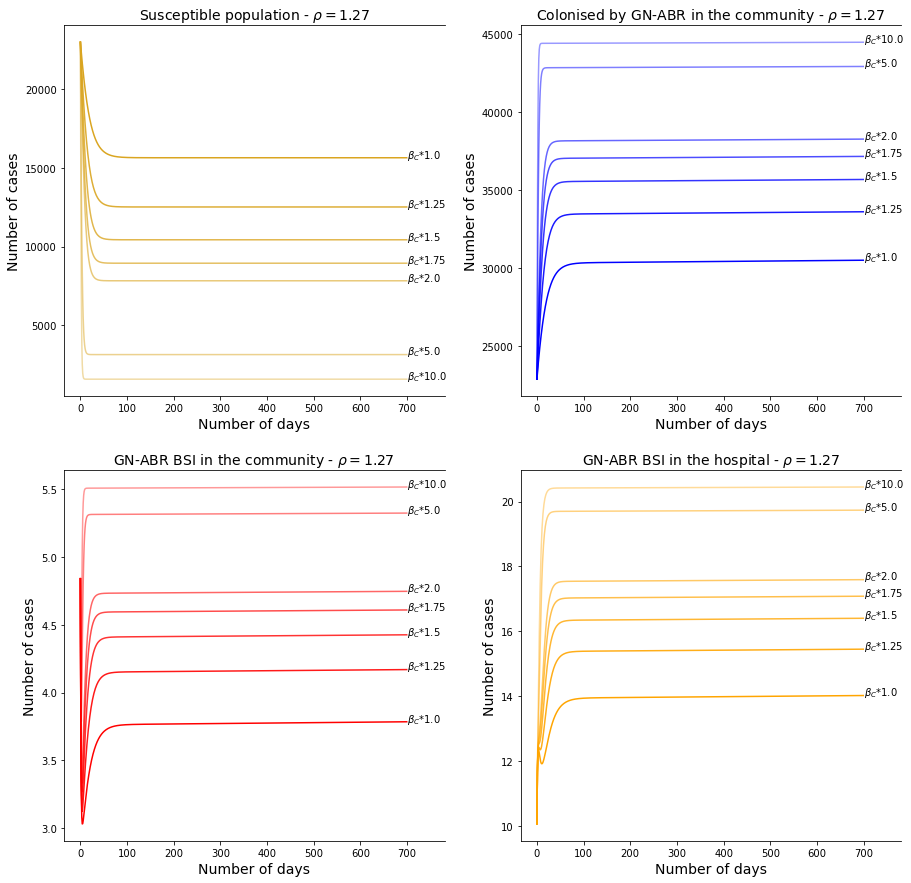

In [54]:
variation = np.array([1, 1.25, 1.5, 1.75, 2, 5, 10]) 
BETA_C = beta_C*variation
RESULTS_BETA_C_highRisk = []

for i in range(len(BETA_C)): 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,alpha,gamma,beta_H,BETA_C[i],omega_H,omega_C,eta,rho[1],delta,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS_BETA_C_highRisk.append(solutions)
    
f, ax = plt.subplots(2,2, figsize=(15,15))


plt.subplot(2,2,1)
for i in range(len(variation)): #Susceptible 
    plt.plot(RESULTS_BETA_C_highRisk[i][:,0], color = colors[compartment_names[0]],alpha=1.0-0.1*i)
    plt.title(r'Susceptible population - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_BETA_C_highRisk[i][:,0][tStop-1],r'$\beta_C$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)

plt.subplot(2,2,2)
for i in range(len(variation)): #Community's Colonized    
    plt.plot(RESULTS_BETA_C_highRisk[i][:,1], color = colors[compartment_names[1]],alpha=1.0-0.1*i)
    plt.title(r'Colonised by GN-ABR in the community - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_BETA_C_highRisk[i][:,1][tStop-1],r'$\beta_C$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)
 
plt.subplot(2,2,3)
for i in range(len(variation)): #Community's Infected
    plt.plot(RESULTS_BETA_C_highRisk[i][:,3], color = colors[compartment_names[3]],alpha=1.0-0.1*i)
    plt.title(r'GN-ABR BSI in the community - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_BETA_C_highRisk[i][:,3][tStop-1],r'$\beta_C$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)    
    
plt.subplot(2,2,4)
for i in range(len(variation)): #Hospital's Infected
    plt.plot(RESULTS_BETA_C_highRisk[i][:,8],  color = colors[compartment_names[8]],alpha=1.0-0.1*i)
    plt.title(r'GN-ABR BSI in the hospital - $\rho=$'+str(rho[1]), fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('Number of cases', fontsize = 14)
    plt.text(tStop+0.5, RESULTS_BETA_C_highRisk[i][:,8][tStop-1],r'$\beta_C$*'+str(variation[i]), fontsize = 10 )
    plt.gca().spines['right'].set_visible(False)
plt.xlim(right=tStop+80)
plt.savefig("TransmisCommu_p_127.pdf", dpi=250)

Table of parameter variations

In [55]:
#  Varying the parameter
variations = BETA_C

#AVIT
#low-risk 
RESULTS_BETA_C_lowRisk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_BETA_C_lowRisk,beta_C,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#high-risk
RESULTS_BETA_C_highRisk_ct_avit = pd.DataFrame(comparative_table_avit(RESULTS_BETA_C_highRisk,beta_C,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])

#MAX
#low risk
RESULTS_BETA_C_lowRisk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_BETA_C_lowRisk,beta_C,variations),
                                        columns = variations,
                                        index = compartment_names[0:-1])
#high risk
RESULTS_BETA_C_highRisk_ct_max = pd.DataFrame(comparative_table_max(RESULTS_BETA_C_highRisk,beta_C,variations),
                                         columns = variations,
                                         index = compartment_names[0:-1])

<ipython-input-2-b2ac5ab27d45>:117: RuntimeWarning: invalid value encountered in true_divide
  comparition = (compartment_i-compartment_baseline)/compartment_baseline


In [45]:
print(RESULTS_BETA_C_lowRisk_ct_avit)
print(RESULTS_BETA_C_highRisk_ct_avit)

          0.000133  0.000166  0.000199  0.000232  0.000265  0.000664  0.001327
$S$            0.0 -0.195481 -0.327327 -0.422133 -0.493545 -0.795899 -0.897405
$Z_C$          0.0  0.148501  0.248796  0.320992  0.375421  0.606419  0.684197
$Z_H$          0.0  0.146966  0.246188  0.317578  0.371370  0.599028  0.675167
$I_C$          0.0  0.148248  0.248372  0.320446  0.374782  0.605360  0.682958
$I_{HC}$       0.0  0.147298  0.246790  0.318414  0.372413  0.601591  0.678760
$I_{HH}$       0.0  0.145761  0.244113  0.314834  0.368091  0.593056  0.668175
$R_C$          0.0  0.138494  0.235213  0.306409  0.360963  0.601498  0.686343
$R_H$          0.0  0.134546  0.228366  0.297335  0.350122  0.581920  0.663080
$I_H$          0.0  0.147224  0.246655  0.318226  0.372178  0.601024  0.677983
          0.000133  0.000166  0.000199  0.000232  0.000265  0.000664  0.001327
$S$            0.0 -0.197451 -0.329949 -0.424945 -0.496360 -0.797575 -0.898319
$Z_C$          0.0  0.102383  0.171267  0.220761  0.

In [46]:
print(RESULTS_BETA_C_lowRisk_ct_max)
print(RESULTS_BETA_C_highRisk_ct_max)

          0.000133  0.000166  0.000199  0.000232  0.000265  0.000664  0.001327
$S$            0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
$Z_C$          0.0  0.149886  0.249778  0.321119  0.374618  0.599273  0.674145
$Z_H$          0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
$I_C$          0.0  0.000000  0.000000  0.000000  0.000000  0.078562  0.129057
$I_{HC}$       0.0  0.149905  0.249811  0.321160  0.374667  0.599350  0.674232
$I_{HH}$       0.0  0.000046  0.000093  0.000139  0.000186  0.000734  0.001588
$R_C$          0.0  0.148458  0.248659  0.320750  0.375077  0.605377  0.682820
$R_H$          0.0  0.147459  0.246995  0.318611  0.372581  0.601385  0.678329
$I_H$          0.0  0.128448  0.226490  0.296508  0.349017  0.569508  0.642993
          0.000133  0.000166  0.000199  0.000232  0.000265  0.000664  0.001327
$S$            0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
$Z_C$          0.0  0.101765  0.169597  0.218042  0.

# Sensitivity analysis: two-way

# 1. Probability of infection in community VS Hospitalization rate for infected people in the community

In [54]:
#Generating the results/outputs

variation_XI_C = np.array([0.2,0.5,0.8,1,1.2,1.5,2,2.5,3,4])
variation_DELTA_I = np.array(range(1,11,1))/10

XI_C = xi_C*variation_XI_C
DELTA_I = delta_I*variation_DELTA_I

label_xi_C = []
label_delta_I = []

RESULTS_XI_C_DELTA_I = []

for r in rho:
    RESULTS_rho = []
    for i in range(len(variation_XI_C)): #run through XI_C
        RESULTS_i = []
        for j in range(len(variation_DELTA_I)): #run through DELTA_I
            if i==0 and r == 1:

                label_delta_I.append(str(variation_DELTA_I[j])+r'*$\delta_I$')

            parameters = Lambda,phi,XI_C[i],xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,r,delta,DELTA_I[j],epsilon

            psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
            IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
            solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista

            RESULTS_i.append(solutions)

        RESULTS_rho.append(RESULTS_i)
        
        if r == 1:
            label_xi_C.append(str(variation_XI_C[i])+r'*$\xi_C$')

    RESULTS_XI_C_DELTA_I.append(RESULTS_rho)
    
    

In [55]:
#collecting data

INFECTIONS_COMMUNITY_XI_C_DELTA_I = []

vmin = 1000
vmax = -1

for k in range(len(rho)): #collecting for each infection risk
    
    INFECTIONS_COMMUNITY_rho = np.zeros([len(variation_XI_C),len(variation_DELTA_I)])

    for i in range(len(variation_XI_C)):
        for j in range(len(variation_DELTA_I)):
            INFECTIONS_COMMUNITY_rho[i,j] = RESULTS_XI_C_DELTA_I[k][i][j][699,3]

        #INFECTIONS_COMMUNITY_rho = pd.DataFrame(INFECTIONS_COMMUNITY_rho)
        
    if vmin > np.amin(INFECTIONS_COMMUNITY_rho):
        vmin = np.amin(INFECTIONS_COMMUNITY_rho)
    
    if vmax < np.amax(INFECTIONS_COMMUNITY_rho):
        vmax = np.amax(INFECTIONS_COMMUNITY_rho)
    
    INFECTIONS_COMMUNITY_XI_C_DELTA_I.append(INFECTIONS_COMMUNITY_rho)

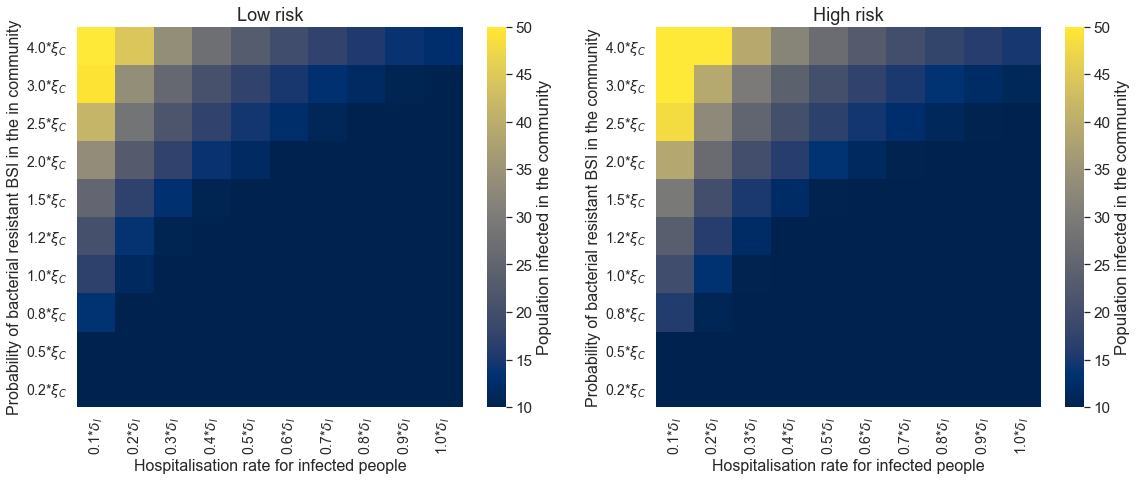

In [67]:
#graphs

f, ax = plt.subplots(1,2, figsize=(19,8))
sns.set(font_scale=1.4)
plt.subplot(1,2,1)
ax1 = sns.heatmap(INFECTIONS_COMMUNITY_XI_C_DELTA_I[0], xticklabels = label_delta_I,cbar_kws={'label': 'Population infected in the community'}, cmap="cividis", yticklabels = label_xi_C, vmin = 10, vmax = 50)
ax1.invert_yaxis()

plt.title(r'Low risk', fontsize = 18)
plt.xlabel('Hospitalisation rate for infected people', fontsize = 16) # x-axis label with fontsize 15
plt.ylabel('Probability of bacterial resistant BSI in the in community', fontsize = 16) # y-axis label with fontsize 15
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.subplot(1,2,2)
ax2 = sns.heatmap(INFECTIONS_COMMUNITY_XI_C_DELTA_I[1], xticklabels = label_delta_I, cmap="cividis",cbar_kws={'label': 'Population infected in the community'}, yticklabels = label_xi_C, vmin = 10, vmax = 50)
ax2.invert_yaxis()
plt.title(r'High risk', fontsize = 18)
plt.xlabel('Hospitalisation rate for infected people', fontsize = 16) # x-axis label with fontsize 15
plt.ylabel('Probability of bacterial resistant BSI in the community', fontsize = 16) # y-axis label with fontsize 15
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#f.suptitle('Individuals infected in the community',fontsize = 16)
plt.savefig("twowaysens_hospitR_probBSI.pdf", dpi=250)

# 2. Probability of infection in community VS Treatment in community 

In [68]:
#Generating the results/outputs

variation_XI_C = np.array([0.2,0.5,0.8,1,1.2,1.5,2,2.5,3,4])
variation_OMEGA_C = np.array([0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 2.0, 2.4,3])


XI_C = xi_C*variation_XI_C
OMEGA_C = omega_C*variation_OMEGA_C

label_xi_C = []
label_omega_C = []

RESULTS_XI_C_OMEGA_C = []

for r in rho:
    RESULTS_rho = []
    for i in range(len(variation_XI_C)): #run through XI_C
        RESULTS_i = []
        for j in range(len(variation_OMEGA_C)): #run through OMEGA_C
            if i==0 and r == 1:

                label_omega_C.append(str(variation_OMEGA_C[j])+r'*$\omega_C$')

            parameters = Lambda,phi,XI_C[i],xi_H,V_C,V_H,alpha,gamma,beta_H,beta_C,omega_H,OMEGA_C[j],eta,r,delta,delta_I,epsilon

            psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
            IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
            solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista

            RESULTS_i.append(solutions)

        RESULTS_rho.append(RESULTS_i)
        
        if r == 1:
            label_xi_C.append(str(variation_XI_C[i])+r'*$\xi_C$')

    RESULTS_XI_C_OMEGA_C.append(RESULTS_rho)
    

In [69]:
#collecting data

INFECTIONS_COMMUNITY_XI_C_OMEGA_C = []

vmin = 1000
vmax = -1

for k in range(len(rho)): #recolecta para cada risk infection
    
    INFECTIONS_COMMUNITY_rho = np.zeros([len(variation_XI_C),len(variation_OMEGA_C)])
    
    for i in range(len(variation_XI_C)):
        for j in range(len(variation_OMEGA_C)):
            INFECTIONS_COMMUNITY_rho[i,j] = RESULTS_XI_C_OMEGA_C[k][i][j][699,3]

        #INFECTIONS_COMMUNITY_rho = pd.DataFrame(INFECTIONS_COMMUNITY_rho)
        
    if vmin > np.amin(INFECTIONS_COMMUNITY_rho):
        vmin = np.amin(INFECTIONS_COMMUNITY_rho)
    
    if vmax < np.amax(INFECTIONS_COMMUNITY_rho):
        vmax = np.amax(INFECTIONS_COMMUNITY_rho)
    
    INFECTIONS_COMMUNITY_XI_C_OMEGA_C.append(INFECTIONS_COMMUNITY_rho)

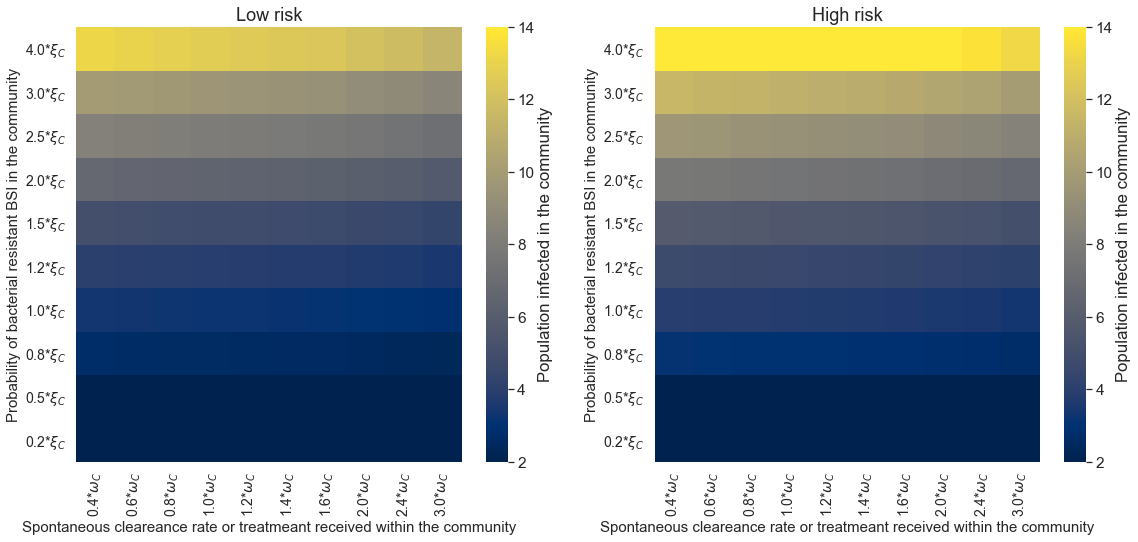

In [76]:
#graphs

f, ax = plt.subplots(1,2, figsize=(19,8))
sns.set(font_scale=1.4)
plt.subplot(1,2,1)
ax1 = sns.heatmap(INFECTIONS_COMMUNITY_XI_C_OMEGA_C[0], xticklabels = label_omega_C,cbar_kws={'label': 'Population infected in the community'}, cmap="cividis", yticklabels = label_xi_C, vmin = 2, vmax = 14)
ax1.invert_yaxis()
plt.title(r'Low risk',fontsize = 18)
plt.xlabel('Spontaneous cleareance rate or treatmeant received within the community', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Probability of bacterial resistant BSI in the community', fontsize = 15) # y-axis label with fontsize 15
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,2,2)
ax2 = sns.heatmap(INFECTIONS_COMMUNITY_XI_C_OMEGA_C[1], xticklabels = label_omega_C, cbar_kws={'label': 'Population infected in the community'},cmap="cividis", yticklabels = label_xi_C, vmin = 2, vmax = 14)
ax2.invert_yaxis()
plt.title(r'High risk',fontsize = 18)
plt.xlabel('Spontaneous cleareance rate or treatmeant received within the community', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Probability of bacterial resistant BSI in the community', fontsize = 15) # y-axis label with fontsize 15
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#f.suptitle('Individuals infected in the community',fontsize = 15)

plt.savefig("twowaysens_spontclear_probBSI.pdf", dpi=250)

# 3. Probability of infection in hospital VS Treatment in hospital

In [77]:
#Generating the results/outputs

variation_XI_H =  np.array([0.2,0.5,0.8,1,1.2,1.5,2,2.5,3,4])
variation_OMEGA_H = np.array([0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 2.0, 2.4,3])


XI_H = xi_C*variation_XI_H
OMEGA_H = omega_C*variation_OMEGA_H

label_xi_H = []
label_omega_H = []

RESULTS_XI_H_OMEGA_H = []

for r in rho:
    RESULTS_rho = []
    for i in range(len(variation_XI_H)): #run through XI_C
        RESULTS_i = []
        for j in range(len(variation_OMEGA_H)): #run through OMEGA_C
            if i==0 and r == 1:

                label_omega_H.append(str(variation_OMEGA_H[j])+r'*$\omega_H$')

            parameters = Lambda,phi,xi_C,XI_H[i],V_C,V_H,alpha,gamma,beta_H,beta_C,OMEGA_H[j],omega_C,eta,r,delta,delta_I,epsilon

            psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
            IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
            solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista

            RESULTS_i.append(solutions)

        RESULTS_rho.append(RESULTS_i)
        
        if r == 1:
            label_xi_H.append(str(variation_XI_H[i])+r'*$\xi_H$')

    RESULTS_XI_H_OMEGA_H.append(RESULTS_rho)
    

In [78]:
#collecting data

INFECTIONS_HOSPITAL_XI_H_OMEGA_H = []

vmin = 1000
vmax = -1

for k in range(len(rho)): #recolecta para cada risk infection
    
    INFECTIONS_HOSPITAL_rho = np.zeros([len(variation_XI_H),len(variation_OMEGA_H)])
    
    for i in range(len(variation_XI_H)):
        for j in range(len(variation_OMEGA_H)):
            INFECTIONS_HOSPITAL_rho[i,j] = RESULTS_XI_H_OMEGA_H[k][i][j][699,8]

        #INFECTIONS_COMMUNITY_rho = pd.DataFrame(INFECTIONS_COMMUNITY_rho)
        
    if vmin > np.amin(INFECTIONS_HOSPITAL_rho):
        vmin = np.amin(INFECTIONS_HOSPITAL_rho)
    
    if vmax < np.amax(INFECTIONS_HOSPITAL_rho):
        vmax = np.amax(INFECTIONS_HOSPITAL_rho)
    
    INFECTIONS_HOSPITAL_XI_H_OMEGA_H.append(INFECTIONS_HOSPITAL_rho)

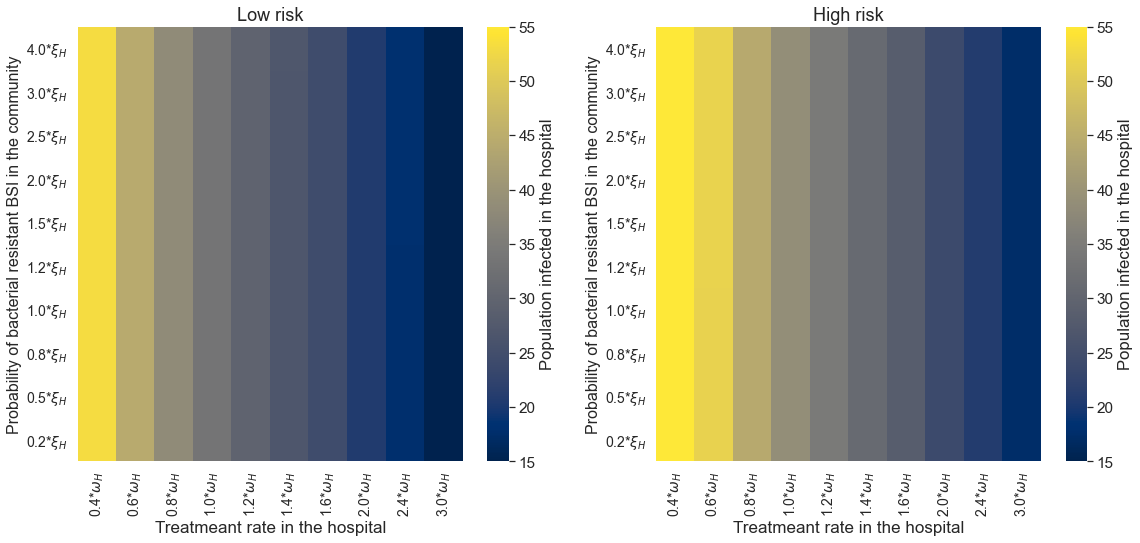

In [81]:
#graphs

f, ax = plt.subplots(1,2, figsize=(19,8))
sns.set(font_scale=1.4)
plt.subplot(1,2,1)
ax1 = sns.heatmap(INFECTIONS_HOSPITAL_XI_H_OMEGA_H[0], xticklabels = label_omega_H, cbar_kws={'label': 'Population infected in the hospital'}, cmap="cividis", yticklabels = label_xi_H, vmin = 15, vmax = 55)
ax1.invert_yaxis()
plt.title(r'Low risk', fontsize = 18)
plt.xlabel('Treatmeant rate in the hospital', fontsize = 17) # x-axis label with fontsize 15
plt.ylabel('Probability of bacterial resistant BSI in the community', fontsize = 16) # y-axis label with fontsize 15
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,2,2)
ax2 = sns.heatmap(INFECTIONS_HOSPITAL_XI_H_OMEGA_H[1], xticklabels = label_omega_H, cbar_kws={'label': 'Population infected in the hospital'}, cmap="cividis", yticklabels = label_xi_H, vmin = 15, vmax = 55)
ax2.invert_yaxis()
plt.title(r'High risk', fontsize = 18)
plt.xlabel('Treatmeant rate in the hospital', fontsize = 17) # x-axis label with fontsize 15
plt.ylabel('Probability of bacterial resistant BSI in the community', fontsize = 16) # y-axis label with fontsize 15
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#f.suptitle('Infected individuals in the hospital',fontsize = 15)
plt.savefig("twowaysens_spontclear_probBSI_H.pdf", dpi=250)

# 4. Hospitalization rate of infected in community vs Mortality rate in hospital coused by bsi

In [160]:
#Generating the results/outputs
variation_DELTA_I = np.array(range(1,11,1))/10
variation_V_H_list = (1+np.array(range(1,11,1))/10)


DELTA_I = delta_I*variation_DELTA_I
V_H_list = V_H*variation_V_H_list

label_delta_I = []
label_V_H = []

RESULTS_DELTA_I_V_H = []

for r in rho:
    RESULTS_rho = []
    for i in range(len(variation_DELTA_I)): #run through DELTA_I
        RESULTS_i = []
        for j in range(len(variation_V_H_list)): #run through V_H
            if i==0 and r == 1:

                label_V_H.append(str(variation_V_H_list[j])+r'*$V_H$')

            parameters = Lambda,phi,xi_C,xi_H,V_C,V_H_list[j],alpha,gamma,beta_H,beta_C,omega_H,omega_C,eta,r,delta,DELTA_I[i],epsilon
            
            psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
            IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
            solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista

            RESULTS_i.append(solutions)

        RESULTS_rho.append(RESULTS_i)
        
        if r == 1:
            label_delta_I.append(str(variation_DELTA_I[i])+r'*$\delta_I$')

    RESULTS_DELTA_I_V_H.append(RESULTS_rho)
    
    

In [161]:
#collecting data

INFECTIONS_HOSPITAL_DELTA_I_V_H = []

vmin = 1000
vmax = -1

for k in range(len(rho)): #recolecta para cada risk infection
    
    INFECTIONS_HOSPITAL_rho = np.zeros([len(variation_DELTA_I),len(variation_V_H_list)])

    for i in range(len(DELTA_I)):
        for j in range(len(V_H_list)):
            INFECTIONS_HOSPITAL_rho[i,j] = RESULTS_DELTA_I_V_H[k][i][j][699,8]

    if vmin > np.amin(INFECTIONS_HOSPITAL_rho):
        vmin = np.amin(INFECTIONS_HOSPITAL_rho)
    
    if vmax < np.amax(INFECTIONS_HOSPITAL_rho):
        vmax = np.amax(INFECTIONS_HOSPITAL_rho)
    
    INFECTIONS_HOSPITAL_DELTA_I_V_H.append(INFECTIONS_HOSPITAL_rho)

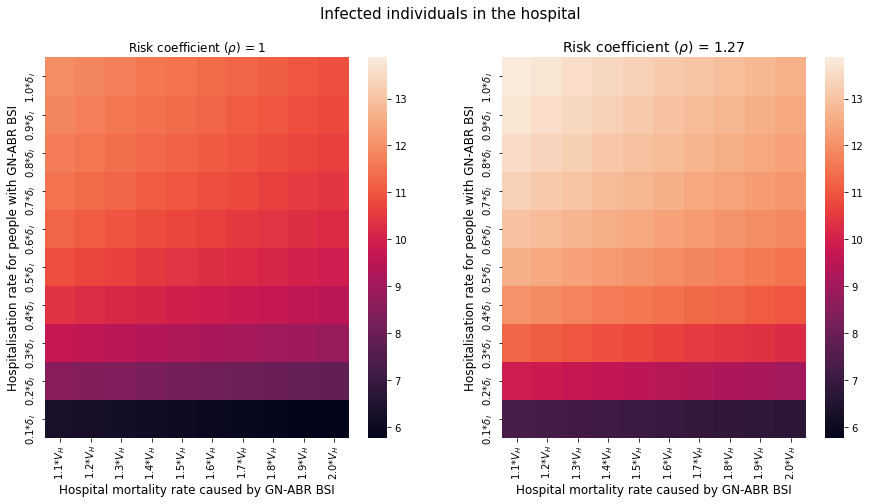

In [162]:
#graphs

f, ax = plt.subplots(1,2, figsize=(15,7))

plt.subplot(1,2,1)
ax1 = sns.heatmap(INFECTIONS_HOSPITAL_DELTA_I_V_H[0], xticklabels = label_V_H, yticklabels = label_delta_I, vmin = vmin, vmax = vmax)
ax1.invert_yaxis()
plt.title(r'Risk coefficient ($\rho$) = 1', fontsize = 12)
plt.xlabel('Hospital mortality rate caused by GN-ABR BSI', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Hospitalisation rate for people with GN-ABR BSI', fontsize = 12) # y-axis label with fontsize 15

plt.subplot(1,2,2)
ax2 = sns.heatmap(INFECTIONS_HOSPITAL_DELTA_I_V_H[1], xticklabels = label_V_H, yticklabels = label_delta_I, vmin = vmin, vmax = vmax)
ax2.invert_yaxis()
plt.title(r'Risk coefficient ($\rho$) = 1.27', fontsize = 14)
plt.xlabel('Hospital mortality rate caused by GN-ABR BSI', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Hospitalisation rate for people with GN-ABR BSI', fontsize = 12) # y-axis label with fontsize 15

f.suptitle('Infected individuals in the hospital',fontsize = 15)
plt.savefig("twowaysens_hospR_mortality_H.pdf", dpi=250)

# Calculating $R_0$

Consider the "infeted compartmen"t the colonized and infected ones 

In [102]:
#Calculating R_0 for rho

R_0 = []

for i in range(len(rho)):

    F = np.array([[rho[i]*epsilon*beta_C*S_0,0,0,0],
                 [0,rho[0]*epsilon*delta*beta_H*S_0,0,0],
                 [0,0,0,0],
                 [0,0,0,0]])

    V = np.array([[xi_C*(1-gamma)*(1-delta)+delta+gamma+phi,-alpha,-omega_C,0],
            [-delta,xi_H*(1-alpha)+alpha+gamma+phi,0,-omega_H],
            [-xi_C*(1-gamma)*(1-delta),0,delta_I+omega_C+phi+(1-omega_C)*(1-delta_I)*eta*V_C,0],
            [0,-xi_H*(1-alpha),delta_I,omega_H+(1-omega_H)*eta*V_H+phi]])

    FV_1 = np.matmul(F,np.linalg.inv(V))
    print(FV_1)
    eigenvalue, eigenvectors = np.linalg.eig(FV_1)
    R_0.append(eigenvalue[0])
    
print(R_0)

[[ 1.15171696e+00  1.04176171e+00 -8.06958317e-01  9.36447503e-01]
 [-2.47883017e-08  2.33270055e-05 -1.95753580e-05  2.09688221e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.46268054e+00  1.32303737e+00 -1.02483706e+00  1.18928833e+00]
 [-2.47883017e-08  2.33270055e-05 -1.95753580e-05  2.09688221e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[1.1517169398599578, 1.462680519676237]


In [103]:
# compute R_t for two rho

R_t = []
for i in range(len(rho)):
    S_i = RESULTS_baseline[i][:,0]
    N_i = np.zeros(len(RESULTS_baseline[i][:,0]))
    for j in range(6):
        N_i+=RESULTS_baseline[i][:,j]
    R_t_i = R_0[i]*(S_i/N_i)
    R_t.append(R_t_i)

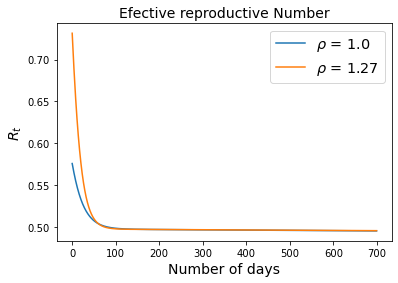

In [107]:
#plot

for i in range(len(rho)):
    plt.plot(R_t[i], label = r'$\rho$ = '+str(rho[i]))
    plt.title('Efective reproductive Number', fontsize = 14)
    plt.xlabel('Number of days', fontsize = 14)
    plt.ylabel('$R_t$',fontsize = 14)
    plt.legend( fontsize='x-large')
    plt.grid(color = 'white')
plt.savefig("Rt_1.pdf", dpi=250)

# END of the code